In [1]:
import pandas as pd
import numpy as np
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.layers import ReLU, GlobalAveragePooling1D
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

import seaborn as sns
import shutil
import re
from tqdm import tqdm

print(tf.config.list_physical_devices('GPU'))

2024-01-18 12:17:47.906114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 12:17:48.643648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.4/targets/x86_64-linux/lib:/home/zheng/anaconda3/envs/pdiot/lib/
2024-01-18 12:17:48.643754: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.4/targets/x86_64-linux/li

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-18 12:17:49.595983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-18 12:17:49.616026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-18 12:17:49.616225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
respeck_df = pd.read_csv('respeck_dataset.csv')

In [3]:
columns_of_interest_initial = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z','subject_id','activity_subtype', 'activity_type','recording_id']
#Subject id is of interest to us as we will split our dataset by subject_id
columns_of_interest_training = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
columns_of_accel_only = ['accel_x', 'accel_y', 'accel_z']

In [4]:
respeck_df = respeck_df.dropna(subset=columns_of_interest_initial).reset_index(drop=True)
respeck_df

,Unnamed: 0,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,subject_id,sensor_type,activity_type,activity_subtype,recording_id
0,0,1697605965,-0.637451,0.083435,0.928894,-1.609375,1.484375,2.812500,s61,respeck,lyingBack,talking,s61_respeck_lyingBack_talking
1,1,1697606005,-0.558594,0.105164,0.892029,-0.671875,5.515625,0.968750,s61,respeck,lyingBack,talking,s61_respeck_lyingBack_talking
2,2,1697606045,-0.513184,0.087830,0.914246,-0.421875,4.734375,2.015625,s61,respeck,lyingBack,talking,s61_respeck_lyingBack_talking
3,3,1697606085,-0.471436,0.101013,0.908630,-0.156250,1.843750,3.031250,s61,respeck,lyingBack,talking,s61_respeck_lyingBack_talking
4,4,1697606125,-0.485352,0.064880,0.916199,-1.421875,0.218750,2.828125,s61,respeck,lyingBack,talking,s61_respeck_lyingBack_talking
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347841,755,1697636165,-0.124268,-0.947327,0.106140,-1.328125,32.140625,-7.390625,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal
2347842,756,1697636205,0.016846,-1.116028,0.225525,0.703125,11.218750,-14.890625,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal
2347843,757,1697636245,0.047119,-1.000549,0.235291,-16.171875,21.750000,6.968750,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal
2347844,758,1697636285,-0.101074,-0.867249,0.209167,0.078125,25.250000,11.281250,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal


In [5]:
respeck_df.activity_subtype.unique()

array(['talking', 'hyperventilating', 'laughing', 'singing', 'eating',
       'breathingNormal', 'coughing'], dtype=object)

In [6]:
df = respeck_df
df['activity_type'] = df['activity_type'].replace(['sitting', 'standing'], 'sitting/standing')
other = ['talking', 'laughing', 'singing', 'eating']
df['activity_subtype'] = df['activity_subtype'].apply(lambda x: 'other' if x in other else x)
df['combined_activity'] = df.apply(lambda row: f"{row['activity_type']}_{row['activity_subtype']}", axis=1)

In [7]:
df

,Unnamed: 0,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,subject_id,sensor_type,activity_type,activity_subtype,recording_id,combined_activity
0,0,1697605965,-0.637451,0.083435,0.928894,-1.609375,1.484375,2.812500,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other
1,1,1697606005,-0.558594,0.105164,0.892029,-0.671875,5.515625,0.968750,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other
2,2,1697606045,-0.513184,0.087830,0.914246,-0.421875,4.734375,2.015625,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other
3,3,1697606085,-0.471436,0.101013,0.908630,-0.156250,1.843750,3.031250,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other
4,4,1697606125,-0.485352,0.064880,0.916199,-1.421875,0.218750,2.828125,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347841,755,1697636165,-0.124268,-0.947327,0.106140,-1.328125,32.140625,-7.390625,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal,shuffleWalking_breathingNormal
2347842,756,1697636205,0.016846,-1.116028,0.225525,0.703125,11.218750,-14.890625,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal,shuffleWalking_breathingNormal
2347843,757,1697636245,0.047119,-1.000549,0.235291,-16.171875,21.750000,6.968750,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal,shuffleWalking_breathingNormal
2347844,758,1697636285,-0.101074,-0.867249,0.209167,0.078125,25.250000,11.281250,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal,shuffleWalking_breathingNormal


In [8]:
task3_acts_list = ['lyingBack_other', 'lyingBack_hyperventilating', 'lyingLeft_other',
       'lyingRight_other', 'sitting/standing_hyperventilating',
       'sitting/standing_other', 
       'lyingStomach_hyperventilating', 'lyingLeft_breathingNormal',
       'sitting/standing_breathingNormal', 'lyingStomach_other',
       'lyingLeft_coughing', 'sitting/standing_coughing',
       'lyingStomach_coughing',
       'lyingRight_breathingNormal', 
       'lyingLeft_hyperventilating',
       'lyingRight_coughing', 
       'lyingRight_hyperventilating', 
       'lyingStomach_breathingNormal', 'lyingBack_coughing',
       'lyingBack_breathingNormal']
len(task3_acts_list)

20

### Preprocessing outliers

**RobustScaler** scales data while being robust to outliers by using the median and interquartile range (IQR): <br>

$x_{\text{scaled}} = \frac{{x - Q2}}{{Q3 - Q1}}$  <br>

Where:
Q1 is the first quartile (25th percentile) of the data.
Q2 is the median (50th percentile) of the data.
Q3 is the third quartile (75th percentile) of the data.

In [9]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
respeck_scaler = scaler.fit(respeck_df[columns_of_accel_only].values)
respeck_df.loc[:,columns_of_accel_only] = respeck_scaler.transform(respeck_df[columns_of_accel_only].to_numpy())

In [10]:
print(f"The data was collected using the sensors: {df.sensor_type.unique()}")
print(f"The data was collected for the activities: {df.activity_type.unique()}")
print(f"The data was collected for the sub-activities: {df.activity_subtype.unique()}")
print(f"The number of unique recordings is: {len(df.recording_id.unique())}")
print(f"The subject IDs in the recordings are: {len(df.subject_id.unique())}")

The data was collected using the sensors: ['respeck']
The data was collected for the activities: ['lyingBack' 'lyingLeft' 'lyingRight' 'sitting/standing' 'descending'
 'lyingStomach' 'ascending' 'normalWalking' 'miscMovement'
 'shuffleWalking' 'running']
The data was collected for the sub-activities: ['other' 'hyperventilating' 'breathingNormal' 'coughing']
The number of unique recordings is: 3096
The subject IDs in the recordings are: 71


### Tools functions

In [11]:
# Splitting data into sliding windows
def group_into_sliding_windows(df, window_size, step_size):

    window_number = 0 # start a counter at 0 to keep track of the window number

    all_overlapping_windows = []


    for rid, group in df.groupby("recording_id"):
        large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

   
        overlapping_windows = large_enough_windows[::step_size] 
        if overlapping_windows:
            for window in overlapping_windows:
                window.loc[:, 'window_id'] = window_number
                window_number += 1


            all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))
        
    final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)
    
    return final_sliding_windows


# def generate_data_from_sliding_windows(final_sliding_windows):
#     X= []
#     y= []
#     for window_id, group in final_sliding_windows.groupby('window_id'):

#         shape = group[columns_of_accel_only].values.shape

#         X.append(group[columns_of_accel_only].values )
#         y.append(class_labels[group["activity_type"].values[0]])
    
#     return X,y


def generate_data_from_sliding_windows(final_sliding_windows):
    X= []
    y= []
    for window_id, group in final_sliding_windows.groupby('window_id'):

        shape = group[columns_of_accel_only].values.shape

        X.append(group[columns_of_accel_only].values )
        y.append(task3_class_labels[group['combined_activity'].values[0]])
    
    return X,y



def convert_values_to_numpy_array(X_train_regenerated, y_train_regenerated, X_test_regenerated, y_test_regenerated):
    
    # #Convert categorical variable (labels) into dummy/indicator variables (one-hot encoding)
    y_train = np.asarray(pd.get_dummies(y_train_regenerated), dtype=np.float32)
    y_test = np.asarray(pd.get_dummies(y_test_regenerated), dtype=np.float32)

    X_train = np.asarray(X_train_regenerated).astype('float32')
    X_test = np.asarray(X_test_regenerated).astype('float32')

    print(f"X_train shape = {X_train.shape}")
    print(f"y_train shape = {y_train.shape}")

    print(f"X_test shape = {X_test.shape}")
    print(f"y_test shape = {y_test.shape}")
    return X_train, y_train, X_test, y_test


# Print Model Report
def show_report(model, history):
    # stats
    y_pred_ohe = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(y_true_labels, y_pred_labels))
    print(task3_class_labels)
          
    cm = confusion_matrix(y_true_labels,y_pred_labels)
    cm_normalised = np.around(cm / cm.astype(np.float).sum(axis=1) , decimals=2)
          
    fig, ax= plt.subplots(figsize=(25, 25))
    # sns.set(font_scale=1.2)
    sns.heatmap(cm_normalised, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(task3_class_labels, rotation=45, ha='right'); 
    ax.yaxis.set_ticklabels(task3_class_labels, rotation=45);
    
    figure_1 = plt.figure(figsize=((10,5)))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
          
    figure_2 = plt.figure(figsize=((10,5)))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
# Save the weights
def save_tflite_model(model, filename, save_folder='./Models/'):
    filename = filename + ".tflite"
    # Convert the TensorFlow model to TFLite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Create the folder if it doesn't exist
    os.makedirs(save_folder, exist_ok=True)

    # Save the TFLite model to the specified folder
    tflite_filename = os.path.join(save_folder, filename)
    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

    print(f'TFLite model saved as "{filename}"')

# Task 3: Offline classification of stationary activities with respiratory symptoms and other behaviors using Respeck accelerometer only

### Grouping stationary activities with respiratory symptoms

In [12]:
columns_of_interests = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z','subject_id','activity_subtype', 'activity_type','recording_id', 'combined_activity']

In [13]:
task3_df = df[df['combined_activity'].isin(task3_acts_list)]
task3_df

,Unnamed: 0,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,subject_id,sensor_type,activity_type,activity_subtype,recording_id,combined_activity
0,0,1697605965,-0.921423,0.375338,0.925137,-1.609375,1.484375,2.812500,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other
1,1,1697606005,-0.795152,0.399405,0.883880,-0.671875,5.515625,0.968750,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other
2,2,1697606045,-0.722439,0.380206,0.908743,-0.421875,4.734375,2.015625,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other
3,3,1697606085,-0.655590,0.394808,0.902459,-0.156250,1.843750,3.031250,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other
4,4,1697606125,-0.677873,0.354786,0.910929,-1.421875,0.218750,2.828125,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347081,755,1697636165,0.717748,0.043267,-1.118033,-0.765625,-1.046875,-0.140625,s33,respeck,lyingStomach,other,s33_respeck_lyingStomach_laughing,lyingStomach_other
2347082,756,1697636205,0.719703,0.041915,-1.093716,-1.484375,-0.156250,-0.468750,s33,respeck,lyingStomach,other,s33_respeck_lyingStomach_laughing,lyingStomach_other
2347083,757,1697636245,0.727912,0.045430,-1.104372,-0.890625,-0.187500,-0.328125,s33,respeck,lyingStomach,other,s33_respeck_lyingStomach_laughing,lyingStomach_other
2347084,758,1697636285,0.718139,0.042726,-1.109016,-0.718750,-0.671875,-0.203125,s33,respeck,lyingStomach,other,s33_respeck_lyingStomach_laughing,lyingStomach_other


In [14]:
task3_df.groupby("combined_activity").size().reset_index(name="count")

,combined_activity,count
0,lyingBack_breathingNormal,53902
1,lyingBack_coughing,52365
2,lyingBack_hyperventilating,51596
3,lyingBack_other,159955
4,lyingLeft_breathingNormal,53802
5,lyingLeft_coughing,52903
6,lyingLeft_hyperventilating,53128
7,lyingLeft_other,160691
8,lyingRight_breathingNormal,53986
9,lyingRight_coughing,53132


### Generate class labels

In [15]:
task3_class_labels = {act: idx for idx, act in enumerate(sorted(task3_acts_list))}
task3_class_labels

{'lyingBack_breathingNormal': 0,
 'lyingBack_coughing': 1,
 'lyingBack_hyperventilating': 2,
 'lyingBack_other': 3,
 'lyingLeft_breathingNormal': 4,
 'lyingLeft_coughing': 5,
 'lyingLeft_hyperventilating': 6,
 'lyingLeft_other': 7,
 'lyingRight_breathingNormal': 8,
 'lyingRight_coughing': 9,
 'lyingRight_hyperventilating': 10,
 'lyingRight_other': 11,
 'lyingStomach_breathingNormal': 12,
 'lyingStomach_coughing': 13,
 'lyingStomach_hyperventilating': 14,
 'lyingStomach_other': 15,
 'sitting/standing_breathingNormal': 16,
 'sitting/standing_coughing': 17,
 'sitting/standing_hyperventilating': 18,
 'sitting/standing_other': 19}

In [16]:
task3_df['activity_label'] = task3_df['combined_activity'].map(task3_class_labels)
task3_df

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,subject_id,sensor_type,activity_type,activity_subtype,recording_id,combined_activity,activity_label
0,0,1697605965,-0.921423,0.375338,0.925137,-1.609375,1.484375,2.812500,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other,3
1,1,1697606005,-0.795152,0.399405,0.883880,-0.671875,5.515625,0.968750,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other,3
2,2,1697606045,-0.722439,0.380206,0.908743,-0.421875,4.734375,2.015625,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other,3
3,3,1697606085,-0.655590,0.394808,0.902459,-0.156250,1.843750,3.031250,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other,3
4,4,1697606125,-0.677873,0.354786,0.910929,-1.421875,0.218750,2.828125,s61,respeck,lyingBack,other,s61_respeck_lyingBack_talking,lyingBack_other,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347081,755,1697636165,0.717748,0.043267,-1.118033,-0.765625,-1.046875,-0.140625,s33,respeck,lyingStomach,other,s33_respeck_lyingStomach_laughing,lyingStomach_other,15
2347082,756,1697636205,0.719703,0.041915,-1.093716,-1.484375,-0.156250,-0.468750,s33,respeck,lyingStomach,other,s33_respeck_lyingStomach_laughing,lyingStomach_other,15
2347083,757,1697636245,0.727912,0.045430,-1.104372,-0.890625,-0.187500,-0.328125,s33,respeck,lyingStomach,other,s33_respeck_lyingStomach_laughing,lyingStomach_other,15
2347084,758,1697636285,0.718139,0.042726,-1.109016,-0.718750,-0.671875,-0.203125,s33,respeck,lyingStomach,other,s33_respeck_lyingStomach_laughing,lyingStomach_other,15


In [17]:
from sklearn.model_selection import LeaveOneGroupOut, GroupShuffleSplit

X_with_subject_id = task3_df[columns_of_interests].reset_index(drop=True)
y_with_subject_id = task3_df['activity_label'].reset_index(drop=True)

In [18]:
# Split by subject id
# gss = GroupShuffleSplit(test_size=0.2, random_state=42)
# gss_generator = gss.split(X_with_subject_id, y_with_subject_id, groups=X_with_subject_id.subject_id)

logo = LeaveOneGroupOut()
logo_generator = logo.split(X_with_subject_id, y_with_subject_id, groups=X_with_subject_id.subject_id)

In [20]:
train_ix, test_ix = next(logo_generator)

X_train_df = X_with_subject_id.loc[train_ix]
X_test_df = X_with_subject_id.loc[test_ix]

y_train_df = y_with_subject_id.loc[train_ix]
y_test_df = y_with_subject_id.loc[test_ix]


print(X_test_df['combined_activity'].unique())
print("Number of activities:", len(X_test_df['combined_activity'].unique()))

#Check how many subject_ids are in each of training and test set
print(f"The subject IDs in the recordings are: {len(task3_df.subject_id.unique())}")
print(f"The subject IDs in the training set are: {len(X_train_df.subject_id.unique())}")
print(f"The subject IDs in the test set are: {len(X_test_df.subject_id.unique())}")

print(f"Testing on subject id: {X_test_df.subject_id.unique()} ")

['lyingStomach_hyperventilating' 'lyingBack_other'
 'sitting/standing_other' 'lyingStomach_breathingNormal'
 'sitting/standing_coughing' 'lyingRight_coughing' 'lyingBack_coughing'
 'sitting/standing_breathingNormal' 'sitting/standing_hyperventilating'
 'lyingLeft_other' 'lyingLeft_coughing' 'lyingRight_other'
 'lyingLeft_hyperventilating' 'lyingStomach_other'
 'lyingLeft_breathingNormal' 'lyingRight_breathingNormal'
 'lyingRight_hyperventilating' 'lyingBack_breathingNormal'
 'lyingBack_hyperventilating' 'lyingStomach_coughing']
Number of activities: 20
The subject IDs in the recordings are: 71
The subject IDs in the training set are: 70
The subject IDs in the test set are: 1
Testing on subject id: ['s1'] 


In [21]:
window_size = 50 # Default value: 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # Default value: 25, this is 50% overlap (step_size=25, window_size=50)

X_train_sliding_windows = group_into_sliding_windows(X_train_df,window_size,step_size)
X_test_sliding_windows = group_into_sliding_windows(X_test_df,window_size,step_size)

In [22]:
X_train_generated, y_train_generated = generate_data_from_sliding_windows(X_train_sliding_windows)
X_test_generated, y_test_generated = generate_data_from_sliding_windows(X_test_sliding_windows)

In [23]:
# #Convert categorical variable (labels) into dummy/indicator variables (one-hot encoding)
X_train, y_train, X_test, y_test = convert_values_to_numpy_array(X_train_generated, y_train_generated, X_test_generated, y_test_generated)

X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)


### Hyperameters setup

In [24]:
batch_size = 64
epochs = 50

# LOO Accuracy Evaluation

## CNN

Tutorial: [1D Convolutional Neural Network Models for Human Activity Recognition](https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/)

1D Conv Layers - which will work on 1D data, for example a single axis from one single sensor (accel, gyro or mag)

2D Conv Layers - suitable if the input data is in the form of an image


In [25]:
def CNN_model_v1(X_train, y_train, X_test, y_test):
    window_size = X_train.shape[1]
    n_features = X_train.shape[2]
    n_classes = len(task3_class_labels)
    
    model = Sequential([
        # CNN layers for spatial feature extraction
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, n_features), padding='same'),
        BatchNormalization(),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        Flatten(),

        # Dense layers for final classification
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Increased neurons and added regularization
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Added regularization
        Dropout(0.3),
        Dense(n_classes, activation='softmax'),  # Output layer
    ])
    
    # Learning rate decay with Adam
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=['accuracy'])
    
    print(f"Training on CNN Model v1:")

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

    callbacks_list = [early_stopping, reduce_lr]

    history = model.fit(X_train, y_train,
        batch_size=batch_size, epochs=epochs, callbacks=callbacks_list,
        validation_data=(X_test, y_test),
    )

    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    print(f'Test accuracy: {test_accuracy *100:.2f}%%')
    
    return model, history, test_loss, test_accuracy

In [26]:
cnn_model_v1, cnn_model_v1_history, _, _ = CNN_model_v1(X_train, y_train, X_test, y_test)

2024-01-18 12:26:47.113606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 12:26:47.114693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-18 12:26:47.114903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-18 12:26:47.115022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Training on CNN Model v1:
Epoch 1/50


2024-01-18 12:26:48.744010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-01-18 12:26:48.969701: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f81f142f530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-18 12:26:48.969759: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-01-18 12:26:48.975519: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-18 12:26:49.085139: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1195/1195 [==============================] - 17s 11ms/step - loss: 1.8369 - accuracy: 0.4959 - val_loss: 1.1919 - val_accuracy: 0.5436 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 13s 11ms/step - loss: 1.2054 - accuracy: 0.5275 - val_loss: 1.0620 - val_accuracy: 0.5163 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 13s 11ms/step - loss: 1.1257 - accuracy: 0.5368 - val_loss: 1.0435 - val_accuracy: 0.5472 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 13s 11ms/step - loss: 1.0828 - accuracy: 0.5480 - val_loss: 0.9294 - val_accuracy: 0.5789 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 13s 11ms/step - loss: 1.0360 - accuracy: 0.5580 - val_loss: 0.8917 - val_accuracy: 0.5617 - lr: 9.3900e-04
Epoch 6/50
1195/1195 [==============================] - 13s 11ms/step - loss: 1.0116 - accuracy: 0.5663 - val_loss: 0.8692 - val_accuracy: 0.6089 - lr: 9.2725e-04
Epoch 7/50
1195/1195 [===========

35/35 [==============================] - 0s 4ms/step
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        29
           1       0.62      0.79      0.70        29
           2       0.67      0.62      0.64        29
           3       0.76      0.72      0.74        87
           4       0.78      1.00      0.88        29
           5       0.89      0.83      0.86        29
           6       0.40      0.07      0.12        29
           7       0.71      0.86      0.78        87
           8       0.97      1.00      0.98        29
           9       0.61      0.76      0.68        29
          10       0.70      0.24      0.36        29
          11       0.73      0.83      0.78        87
          12       0.57      0.41      0.48        29
      

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

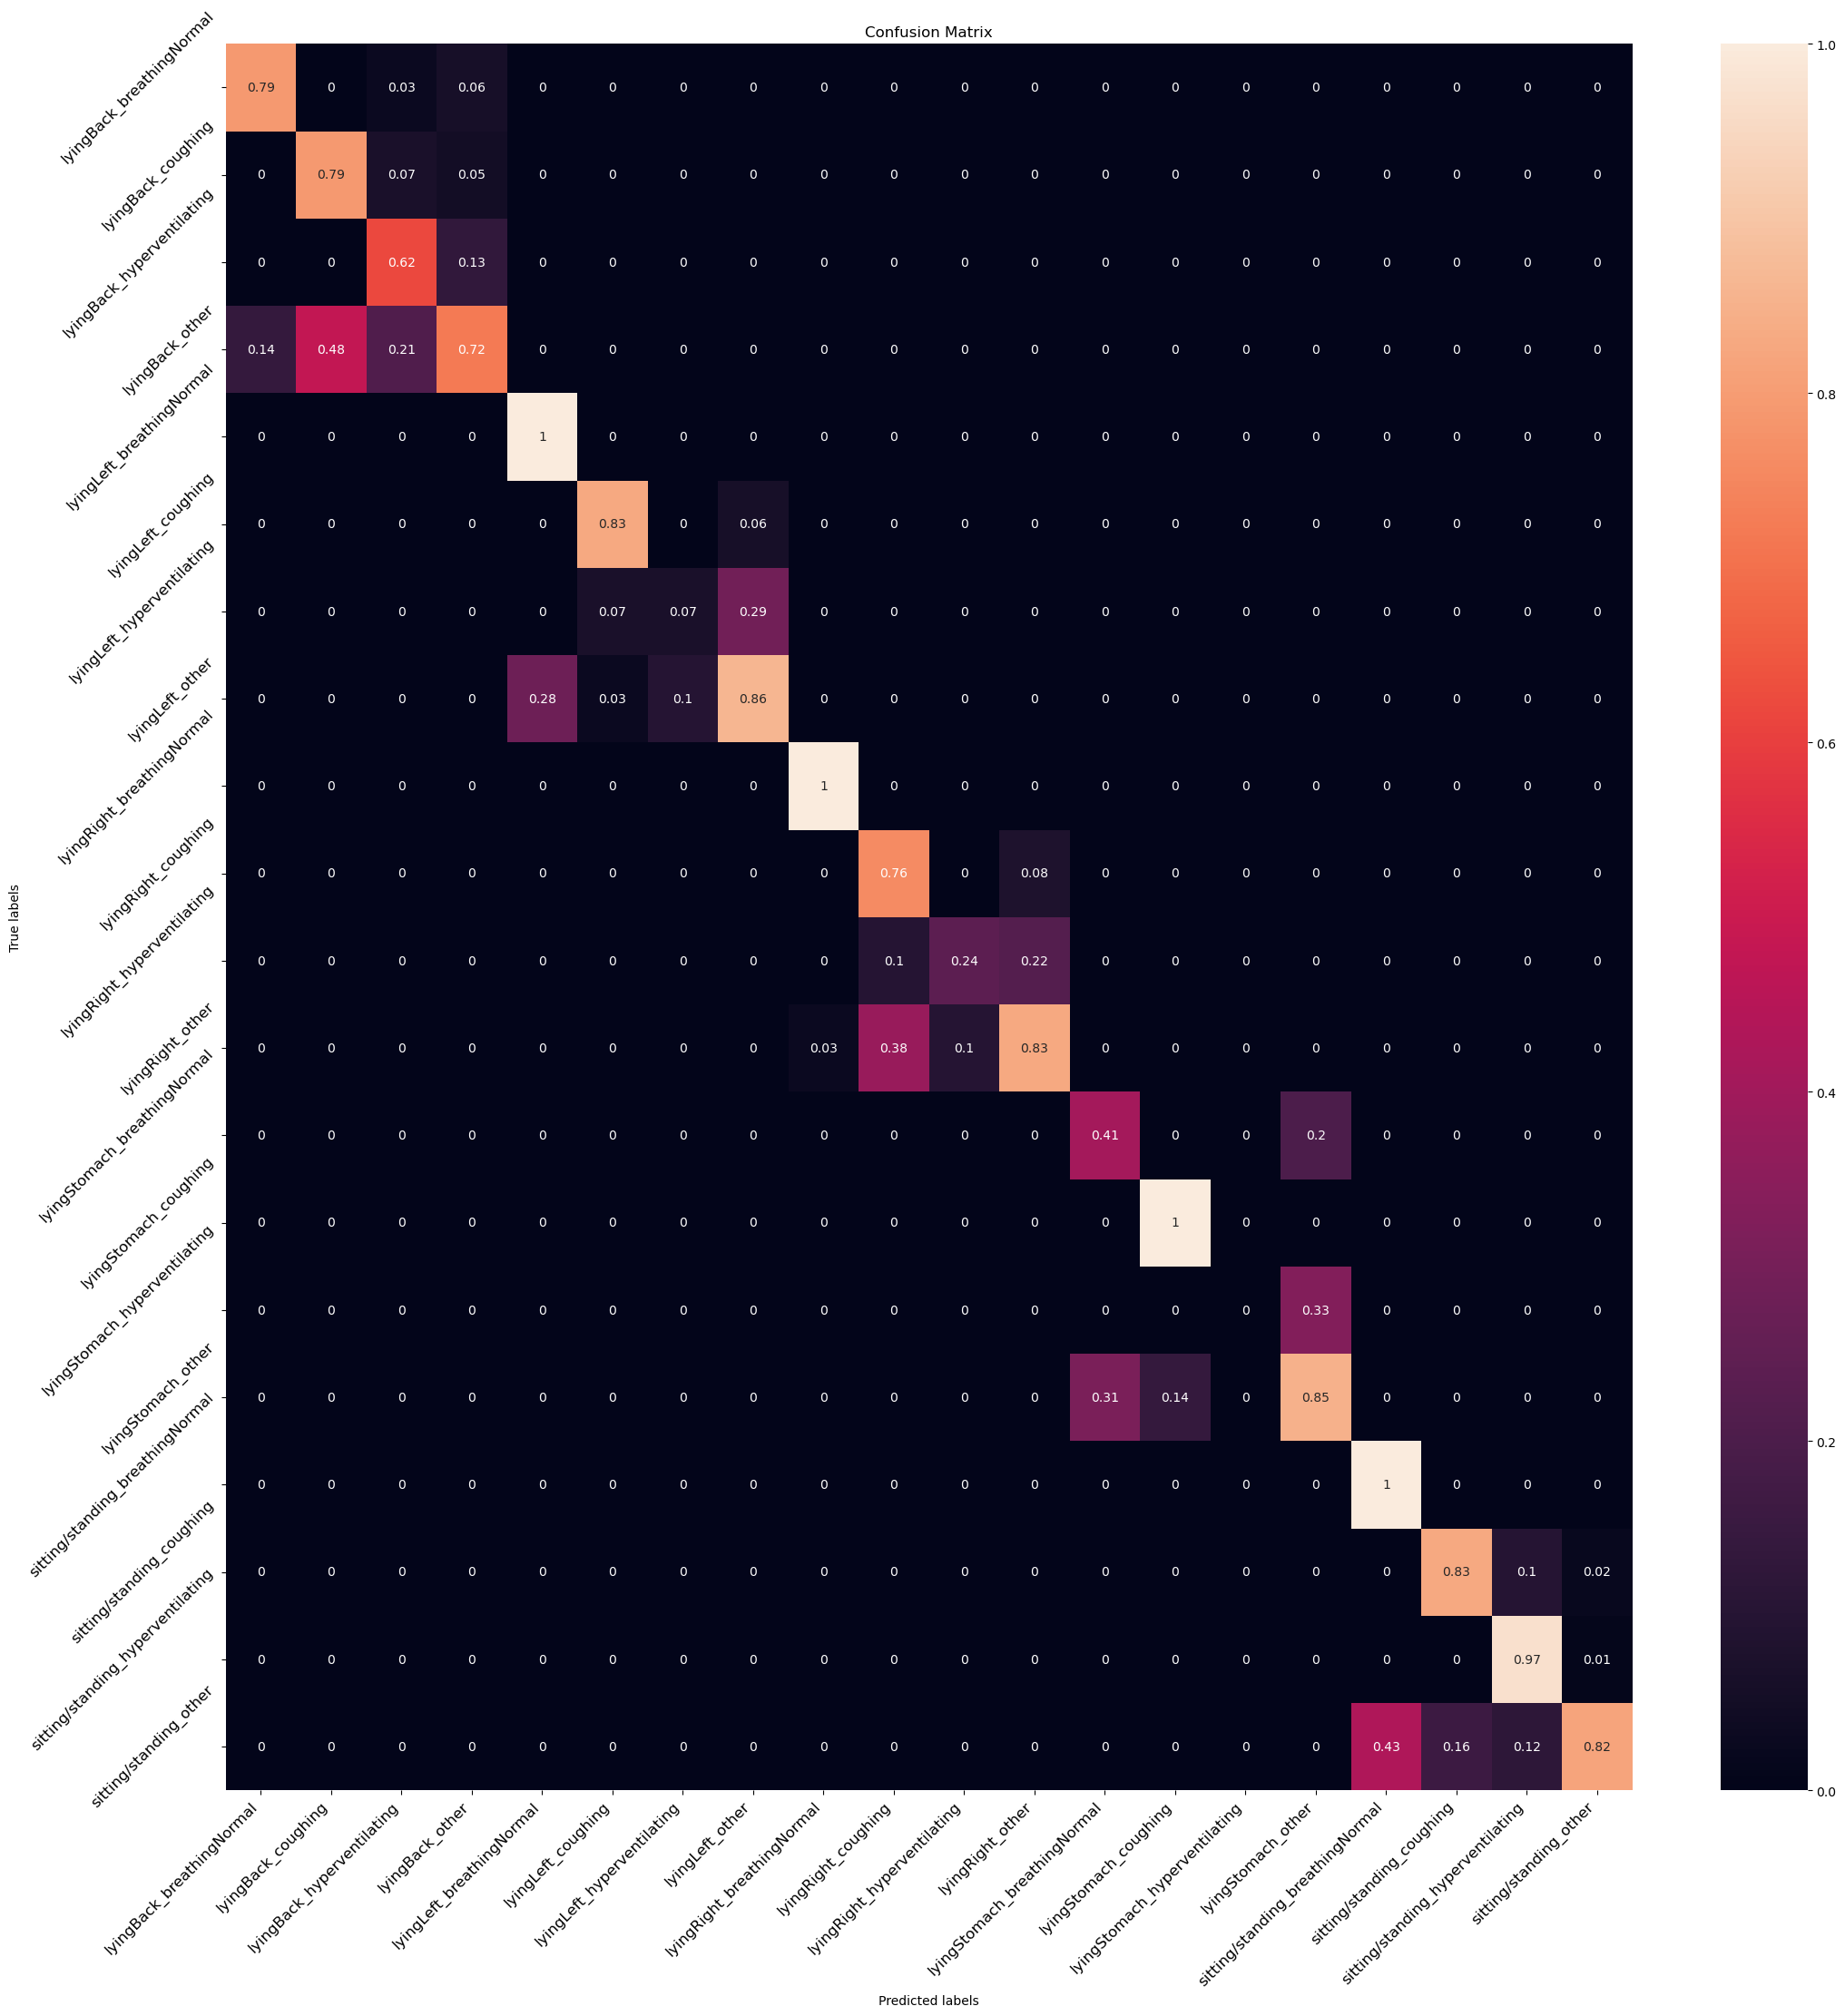

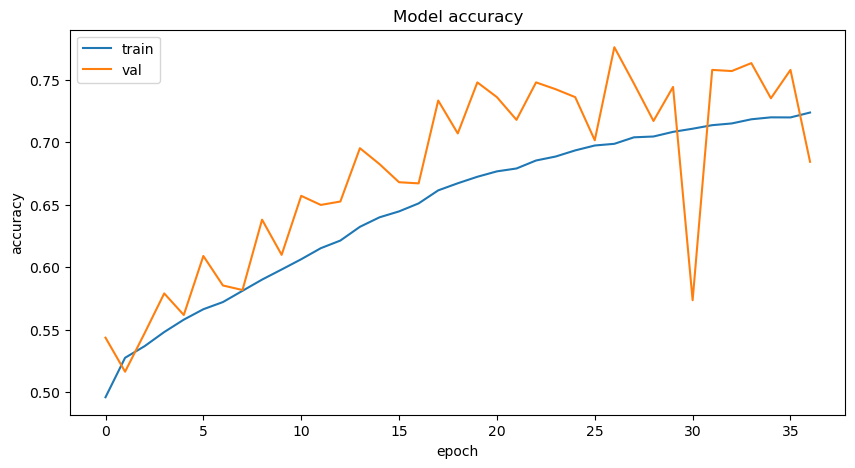

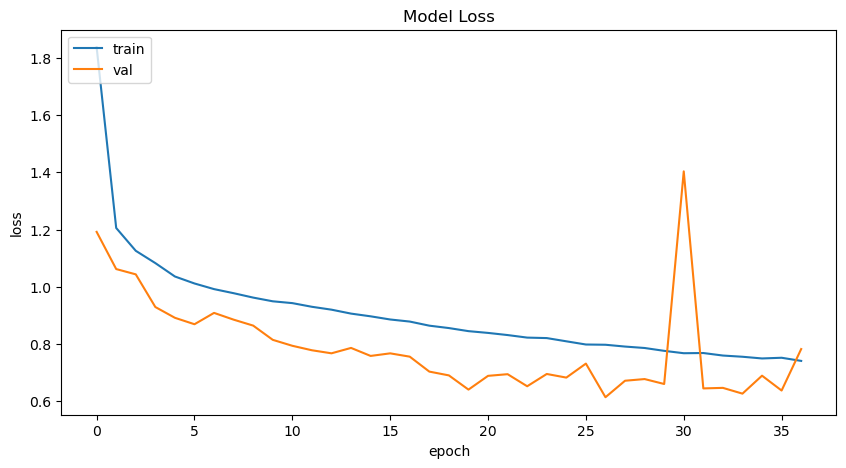

In [27]:
show_report(cnn_model_v1, cnn_model_v1_history)

In [28]:
def CNN_model_v2(X_train, y_train, X_test, y_test):
    window_size = X_train.shape[1]
    n_features = X_train.shape[2]
    n_classes = len(task3_class_labels)
    
    model = Sequential([
        Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(window_size, n_features), padding='same'),
        BatchNormalization(),
        Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),

        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        
        Flatten(),

        Dense(256, activation='relu', kernel_regularizer=l2(0.005)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
        Dropout(0.5),
        Dense(n_classes, activation='softmax'),
    ])
    
    # Adjusted learning rate and decay
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=5e-4,
        decay_steps=8000,
        decay_rate=0.95)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
    
    print(f"Training on CNN Model v2:")

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

    callbacks_list = [early_stopping, reduce_lr]

    history = model.fit(X_train, y_train,
        batch_size=batch_size, epochs=epochs, callbacks=callbacks_list,
        validation_data=(X_test, y_test), shuffle=True
    )

    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    print(f'Test accuracy: {test_accuracy *100:.2f}%%')
    
    return model, history, test_loss, test_accuracy

In [29]:
cnn_model_v2, cnn_model_v2_history, _, _ = CNN_model_v2(X_train, y_train, X_test, y_test)

Training on CNN Model v2:
Epoch 1/50
1195/1195 [==============================] - 17s 11ms/step - loss: 2.6869 - accuracy: 0.4623 - val_loss: 1.5095 - val_accuracy: 0.5263 - lr: 4.9619e-04
Epoch 2/50
1195/1195 [==============================] - 13s 11ms/step - loss: 1.4085 - accuracy: 0.5219 - val_loss: 1.2558 - val_accuracy: 0.5136 - lr: 4.9240e-04
Epoch 3/50
1195/1195 [==============================] - 13s 11ms/step - loss: 1.2641 - accuracy: 0.5264 - val_loss: 1.1676 - val_accuracy: 0.5417 - lr: 4.8864e-04
Epoch 4/50
1195/1195 [==============================] - 13s 11ms/step - loss: 1.2213 - accuracy: 0.5279 - val_loss: 1.1236 - val_accuracy: 0.5100 - lr: 4.8491e-04
Epoch 5/50
1195/1195 [==============================] - 13s 11ms/step - loss: 1.1973 - accuracy: 0.5314 - val_loss: 1.0635 - val_accuracy: 0.5118 - lr: 4.8121e-04
Epoch 6/50
1195/1195 [==============================] - 13s 11ms/step - loss: 1.1346 - accuracy: 0.5363 - val_loss: 0.9991 - val_accuracy: 0.5045 - lr: 4.7754e

1195/1195 [==============================] - 13s 11ms/step - loss: 0.6291 - accuracy: 0.7842 - val_loss: 0.7502 - val_accuracy: 0.7151 - lr: 3.4350e-04
Epoch 50/50
35/35 [==============================] - 0s 5ms/step - loss: 0.5796 - accuracy: 0.7931
Test accuracy: 79.31%%


35/35 [==============================] - 0s 4ms/step
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.96      0.86      0.91        29
           1       0.67      1.00      0.81        29
           2       1.00      0.59      0.74        29
           3       0.89      0.90      0.89        87
           4       0.76      1.00      0.87        29
           5       0.68      0.90      0.78        29
           6       0.40      0.28      0.33        29
           7       0.79      0.71      0.75        87
           8       1.00      0.97      0.98        29
           9       0.49      0.72      0.58        29
          10       0.85      0.59      0.69        29
          11       0.82      0.78      0.80        87
          12       0.64      0.48      0.55        29
      

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/ipykernel_launcher.py:85: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


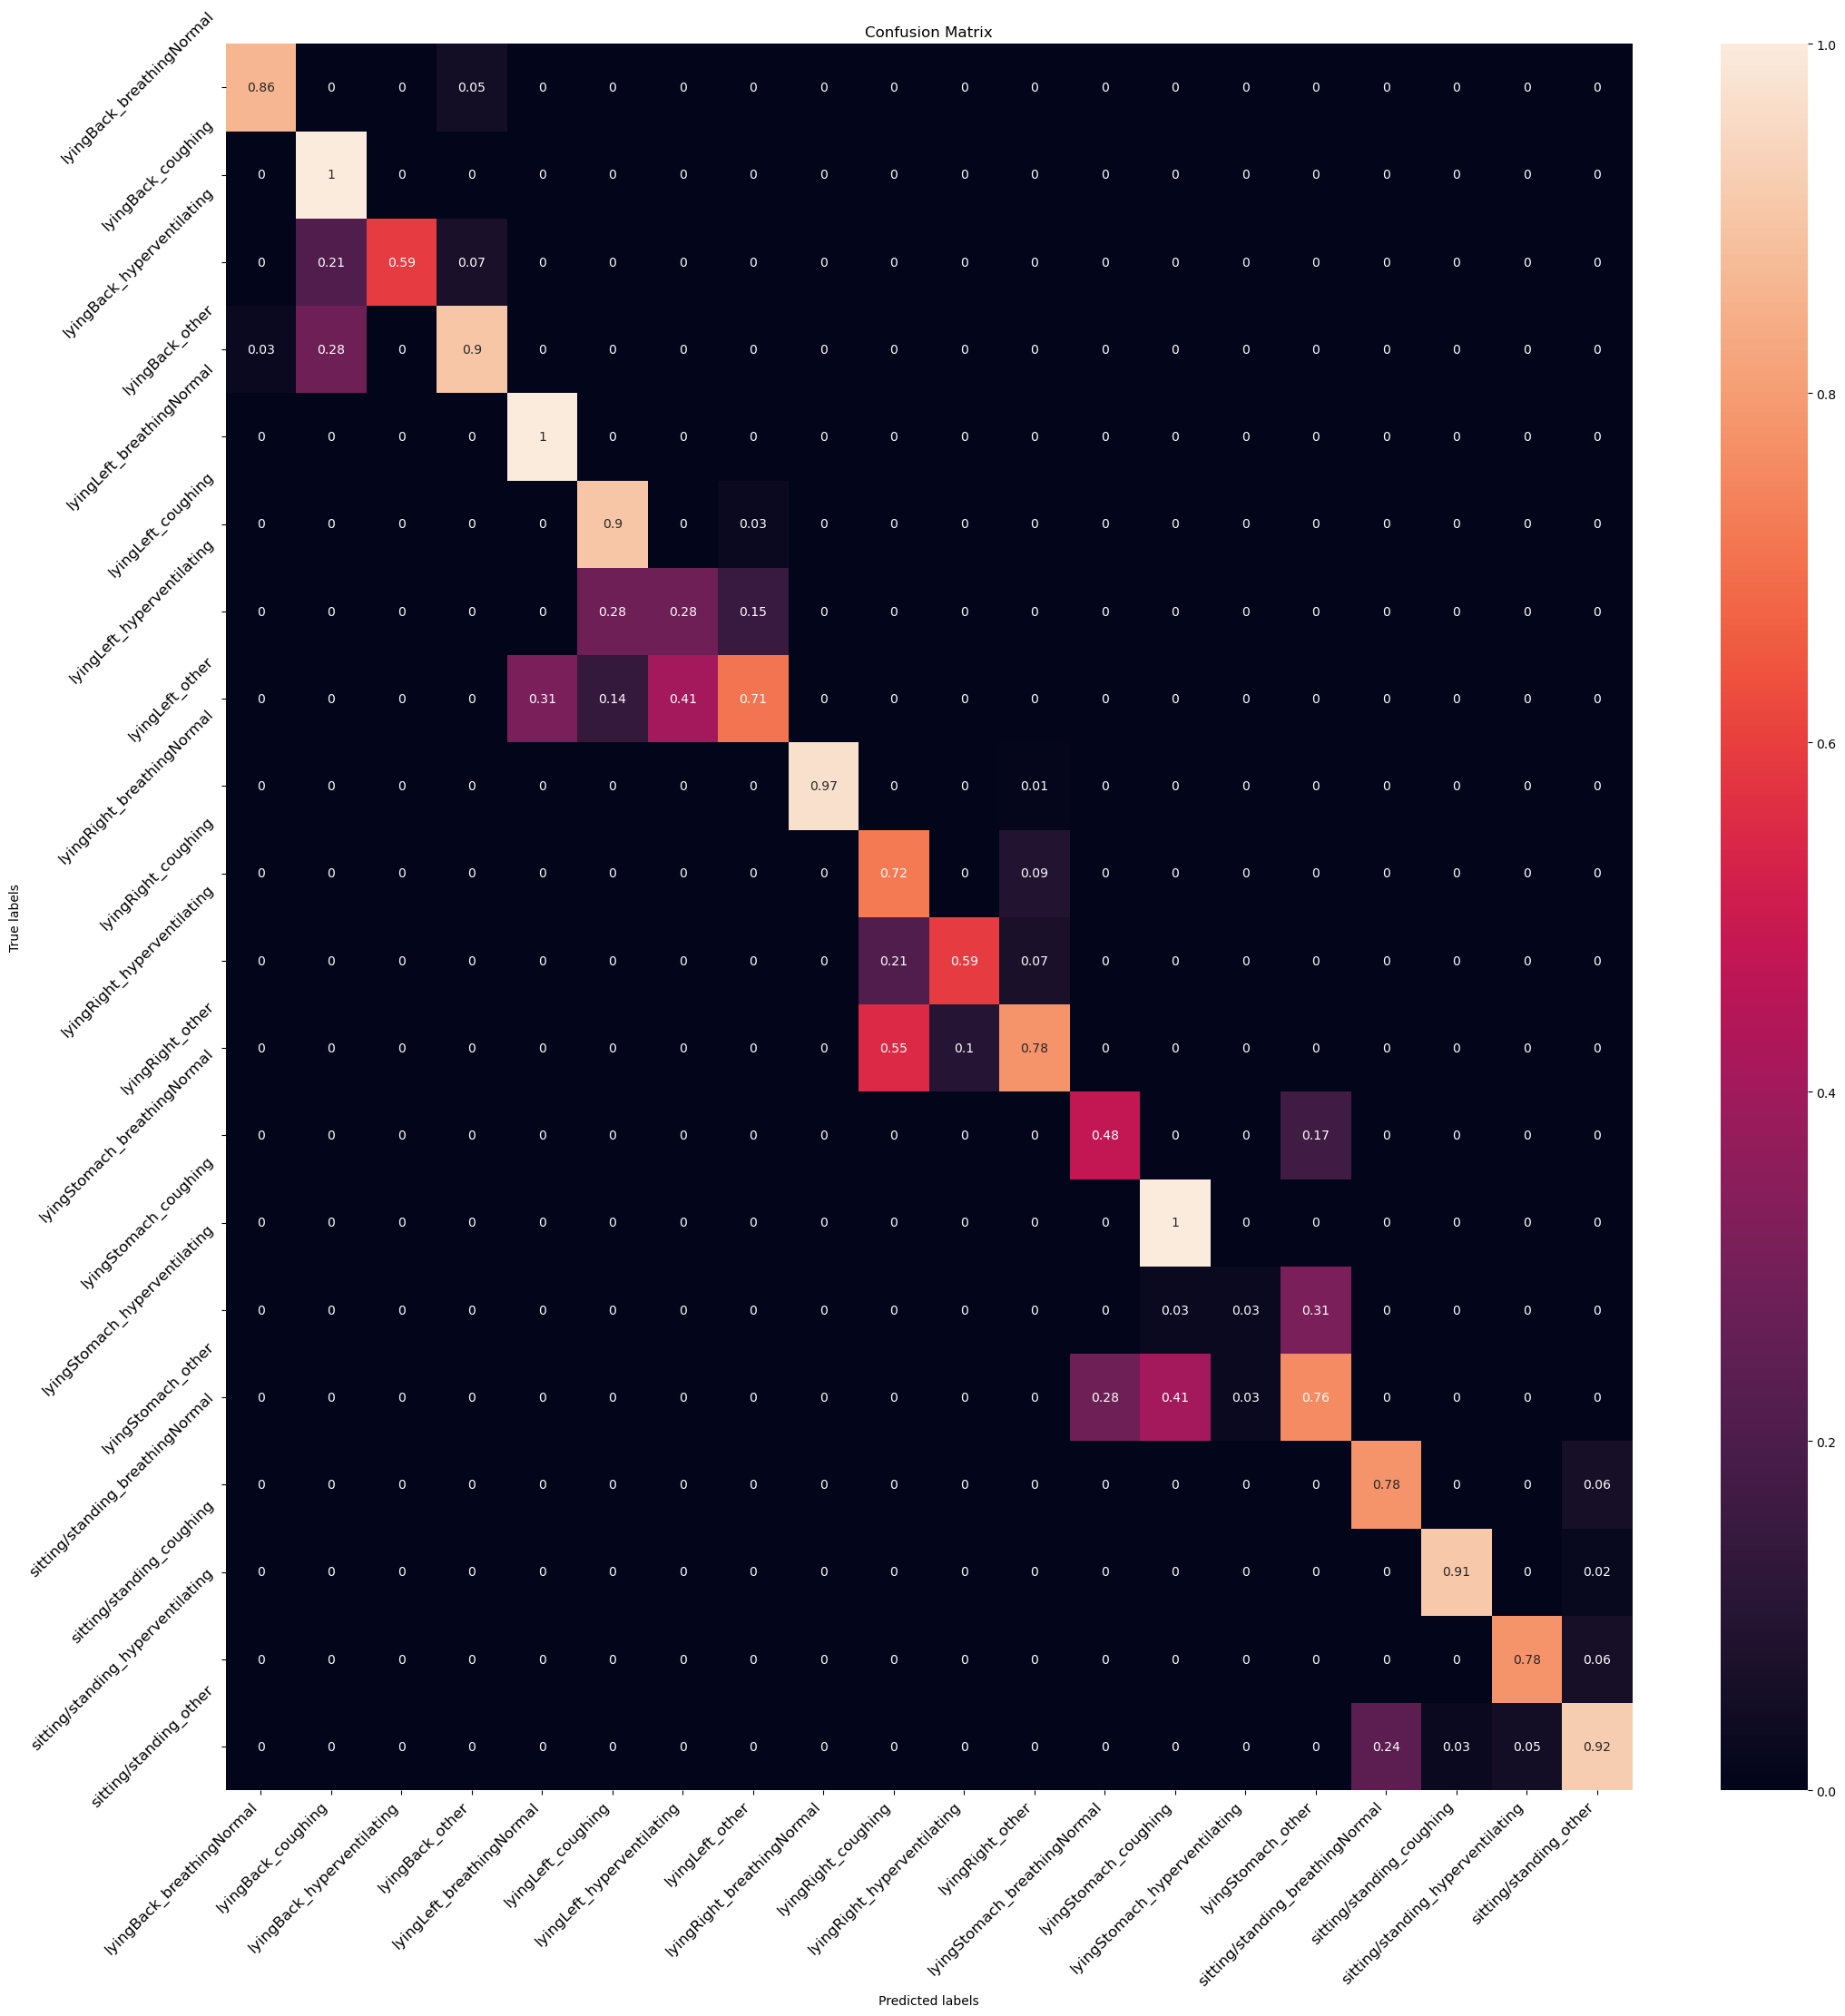

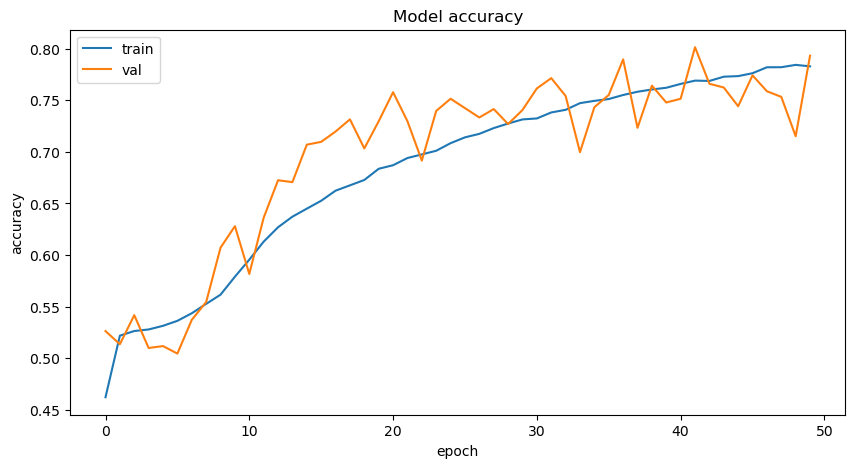

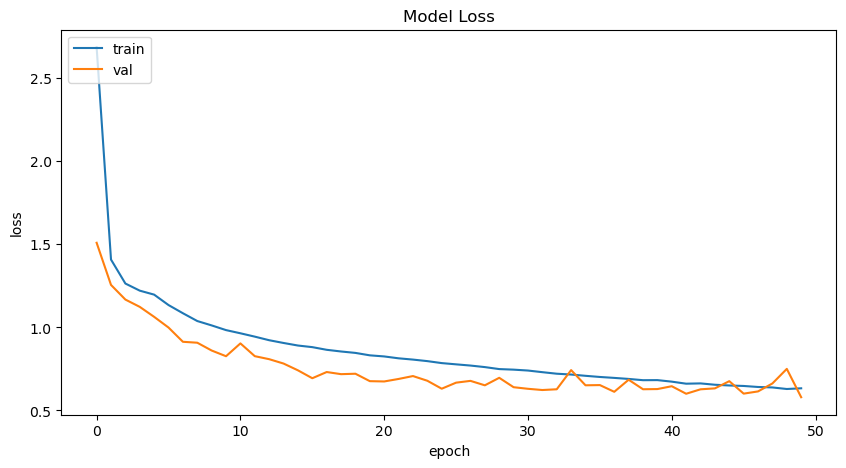

In [30]:
show_report(cnn_model_v2, cnn_model_v2_history)

In [31]:
def CNN_model_v3(X_train, y_train, X_test, y_test):
    window_size = X_train.shape[1]
    n_features = X_train.shape[2]
    n_classes = len(task3_class_labels)
    
    model = Sequential([
        # First block with residual connection
        Conv1D(filters=128, kernel_size=5, padding='same', input_shape=(window_size, n_features)),
        BatchNormalization(),
        ReLU(),
        Conv1D(filters=128, kernel_size=5, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Second block with residual connection
        Conv1D(filters=256, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv1D(filters=256, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        GlobalAveragePooling1D(),

        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(n_classes, activation='softmax')
    ])
    
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
    
    print(f"Training on CNN Model v3:")

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

    callbacks_list = [early_stopping, reduce_lr]

    history = model.fit(X_train, y_train,
        batch_size=batch_size, epochs=epochs, callbacks=callbacks_list,
        validation_data=(X_test, y_test), shuffle=True
    )

    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    print(f'Test accuracy: {test_accuracy *100:.2f}%%')
    
    return model, history, test_loss, test_accuracy

In [32]:
cnn_model_v3, cnn_model_v3_history, test_loss, test_accuracy = CNN_model_v3(X_train, y_train, X_test, y_test)

Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 18s 13ms/step - loss: 1.5278 - accuracy: 0.5039 - val_loss: 1.2234 - val_accuracy: 0.5535 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.1623 - accuracy: 0.5363 - val_loss: 0.9936 - val_accuracy: 0.5336 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0781 - accuracy: 0.5405 - val_loss: 0.9393 - val_accuracy: 0.5318 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0357 - accuracy: 0.5482 - val_loss: 0.8598 - val_accuracy: 0.5617 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0077 - accuracy: 0.5594 - val_loss: 0.8796 - val_accuracy: 0.5245 - lr: 9.3900e-04
Epoch 6/50
1195/1195 [==============================] - 15s 13ms/step - loss: 0.9809 - accuracy: 0.5657 - val_loss: 0.8213 - val_accuracy: 0.6034 - lr: 9.2725e

35/35 [==============================] - 0s 4ms/step
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        29
           1       0.87      0.93      0.90        29
           2       0.75      0.52      0.61        29
           3       0.80      0.86      0.83        87
           4       0.59      1.00      0.74        29
           5       0.85      0.97      0.90        29
           6       0.94      0.52      0.67        29
           7       0.83      0.72      0.77        87
           8       1.00      1.00      1.00        29
           9       0.64      0.62      0.63        29
          10       0.84      0.93      0.89        29
          11       0.87      0.85      0.86        87
          12       0.58      0.76      0.66        29
      

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/ipykernel_launcher.py:85: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


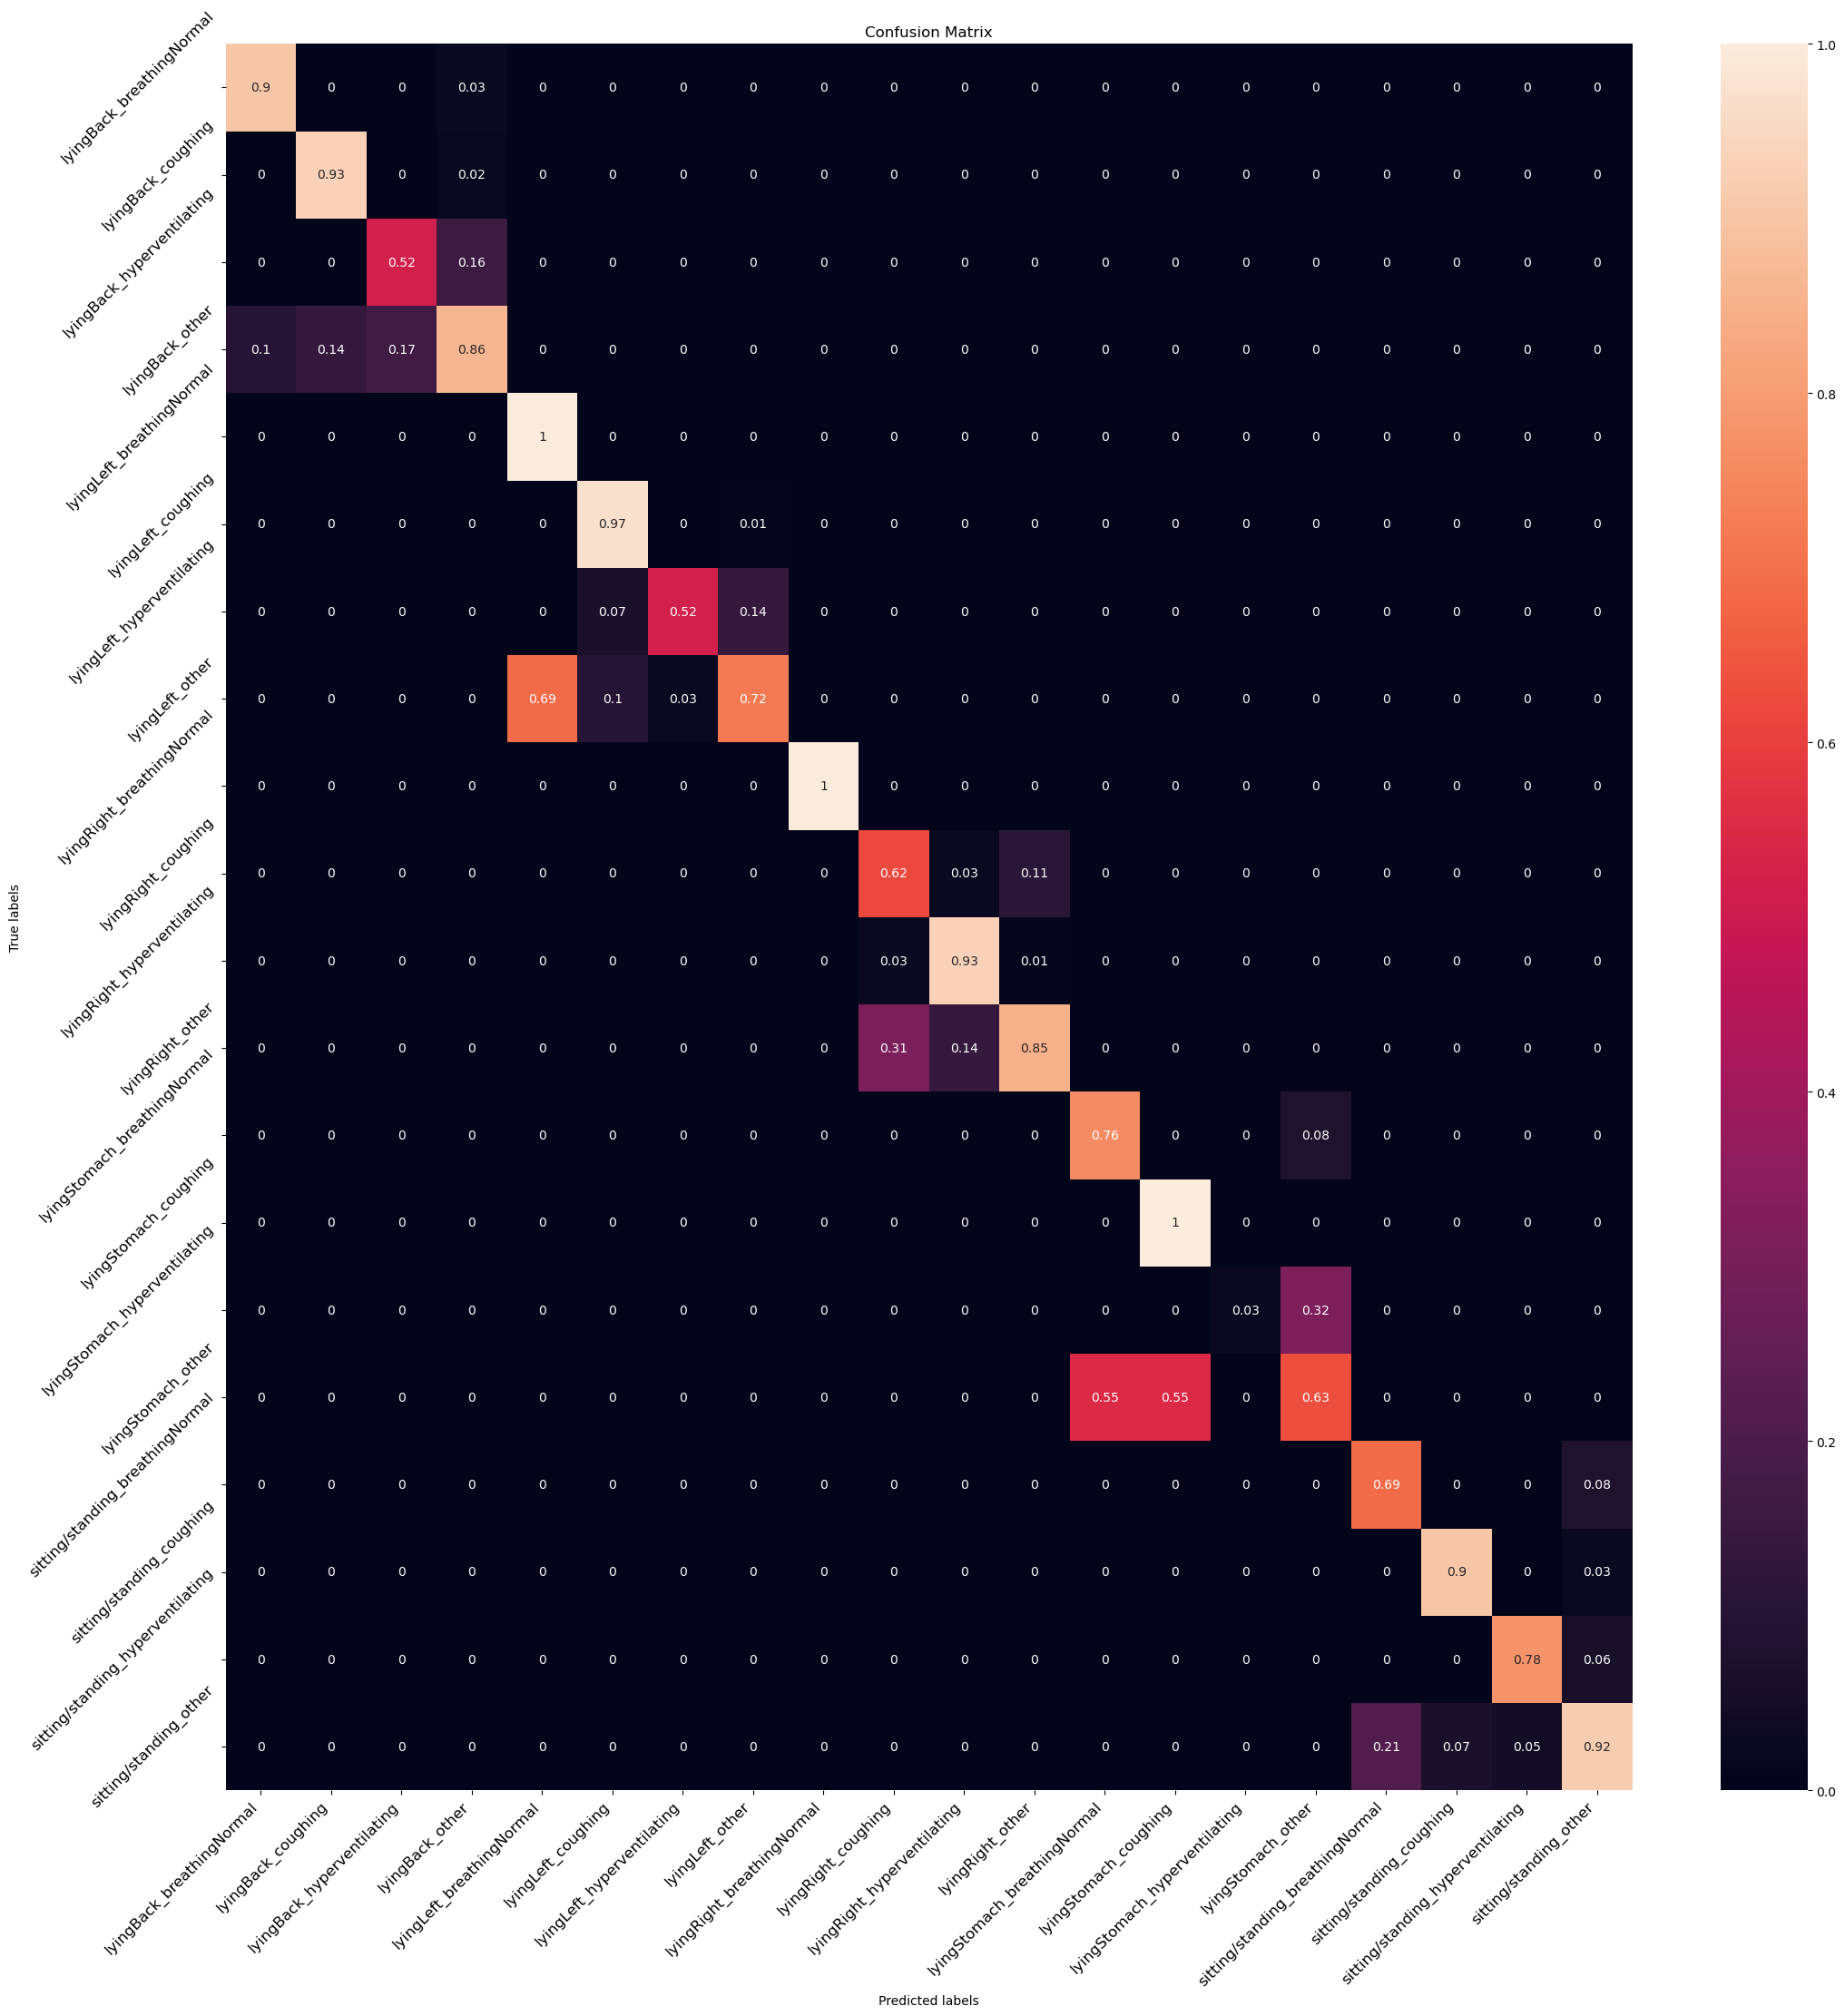

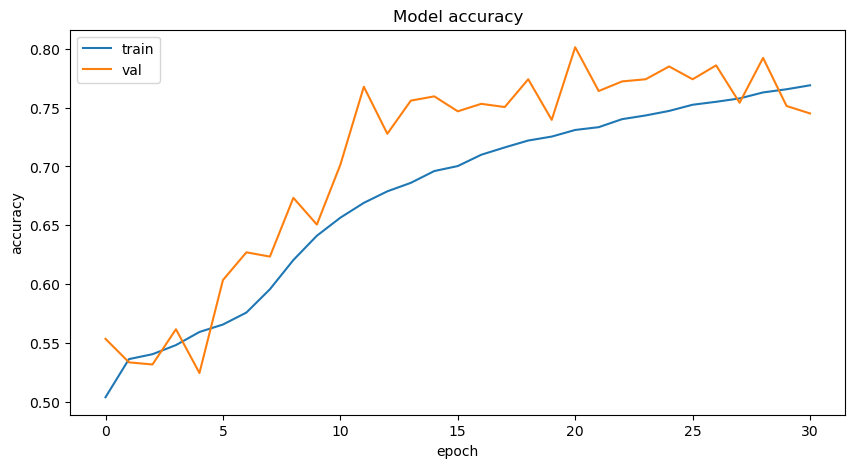

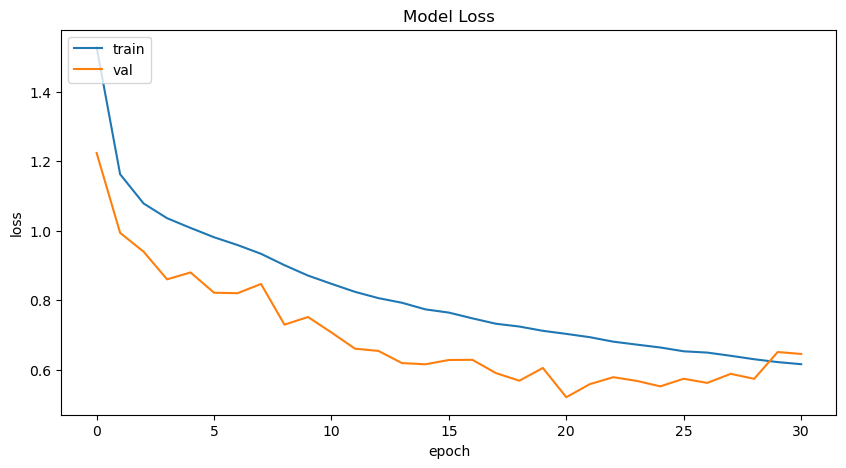

In [33]:
show_report(cnn_model_v3, cnn_model_v3_history)

In [38]:
# save_tflite_model(cnn_model_v3, 'task3_cnn_model_v1_acc70.tflite')

# Download Models

In [34]:
from tensorflow.keras.models import load_model

In [35]:
cnn_model_v1.save('Task3_CNN_Model_v1.h5')

In [36]:
cnn_model_v2.save('Task3_CNN_Model_v2.h5')

In [37]:
cnn_model_v3.save('Task3_CNN_Model_v3.h5')

In [38]:
savedModel=load_model('Task3_CNN_Model_v1.h5')
savedModel.evaluate(X_test, y_test)

35/35 [==============================] - 0s 5ms/step - loss: 0.6143 - accuracy: 0.7759


[0.6142845749855042, 0.7758620977401733]

In [39]:
savedModel=load_model('Task3_CNN_Model_v2.h5')
savedModel.evaluate(X_test, y_test)

35/35 [==============================] - 0s 5ms/step - loss: 0.5796 - accuracy: 0.7931


[0.5796255469322205, 0.7931034564971924]

In [40]:
savedModel=load_model('Task3_CNN_Model_v3.h5')
savedModel.evaluate(X_test, y_test)

35/35 [==============================] - 0s 5ms/step - loss: 0.5205 - accuracy: 0.8013


[0.5205416083335876, 0.8012704253196716]

In [39]:
loo_model_histories = {}
loo_model_accuracies = {}
logo = LeaveOneGroupOut()

y_predictions = []
y_truth = []

window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap (step_size=25)
n_classes = 20

for train_ix, test_ix in logo.split(X_with_subject_id, y_with_subject_id, groups=X_with_subject_id.subject_id):
    
    X_train_df = X_with_subject_id.loc[train_ix]
    X_test_df = X_with_subject_id.loc[test_ix]

    y_train_df = y_with_subject_id.loc[train_ix]
    y_test_df = y_with_subject_id.loc[test_ix]


    X_train_sliding_windows = group_into_sliding_windows(X_train_df,window_size,step_size)
    X_test_sliding_windows = group_into_sliding_windows(X_test_df,window_size,step_size)

    X_train_generated, y_train_generated = generate_data_from_sliding_windows(X_train_sliding_windows)
    X_test_generated, y_test_generated = generate_data_from_sliding_windows(X_test_sliding_windows)
    
    X_train, y_train, X_test, y_test = convert_values_to_numpy_array(X_train_generated, y_train_generated, X_test_generated, y_test_generated)


    if y_test.shape[1] < n_classes:
            print(f"Skipping this subject:{X_test_df.subject_id.unique()}")
            continue
    else:
            print(f"Testing on subject id:{X_test_df.subject_id.unique()}")

    # model, history = CNN_model_v1(X_train, y_train, X_test, y_test)
    # model, history = CNN_model_v2(X_train, y_train, X_test, y_test)
    model, history, test_loss, test_accuracy = CNN_model_v3(X_train, y_train, X_test, y_test)

    print(f"LOO Test Accuracy : {test_accuracy}")
    # stats
    y_pred_ohe = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    print(y_pred_labels)
    
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(y_true_labels, y_pred_labels))
    print(task3_class_labels)
    
    loo_model_histories[X_test_df.subject_id.unique()[0]] = history
    loo_model_accuracies[X_test_df.subject_id.unique()[0]] = test_accuracy
    
    y_predictions.extend(y_pred_labels)
    y_truth.extend(y_true_labels)

X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s1']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 22s 15ms/step - loss: 1.5307 - accuracy: 0.5051 - val_loss: 1.2053 - val_accuracy: 0.5254 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 17s 15ms/step - loss: 1.1866 - accuracy: 0.5333 - val_loss: 1.0001 - val_accuracy: 0.5408 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 17s 15ms/step - loss: 1.0898 - accuracy: 0.5420 - val_loss: 0.9861 - val_accuracy: 0.5526 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 18s 15ms/step - loss: 1.0450 - accuracy: 0.5482 - val_loss: 0.9093 - val_accuracy: 0.5762 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 17s 15ms/step - loss: 1.0150 - accuracy: 0.5543 - val_loss: 0.8734 - val_accuracy: 0.5726 - lr: 9.3900e-04
Epoch 6/50
1195/

X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s100']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 20s 14ms/step - loss: 1.5666 - accuracy: 0.5015 - val_loss: 1.2850 - val_accuracy: 0.4764 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 17s 14ms/step - loss: 1.1910 - accuracy: 0.5351 - val_loss: 1.1477 - val_accuracy: 0.5064 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 17s 14ms/step - loss: 1.0797 - accuracy: 0.5408 - val_loss: 1.0112 - val_accuracy: 0.5054 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 17s 14ms/step - loss: 1.0361 - accuracy: 0.5470 - val_loss: 0.9967 - val_accuracy: 0.5281 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 18s 15ms/step - loss: 0.9989 - accuracy: 0.5578 - val_loss: 0.9292 - val_accuracy: 0.5508 - lr: 9.3900e-04
Epoch 6/50
119

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s102']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 21s 14ms/step - loss: 1.5744 - accuracy: 0.5026 - val_loss: 1.2964 - val_accuracy: 0.5290 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.2516 - accuracy: 0.5270 - val_loss: 1.1353 - val_accuracy: 0.5481 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.1129 - accuracy: 0.5359 - val_loss: 1.1744 - val_accuracy: 0.5154 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0553 - accuracy: 0.5401 - val_loss: 1.2116 - val_accuracy: 0.4973 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 17s 14ms/step - loss: 1.0188 - accuracy: 0.5483 - val_loss: 1.1084 - val_accuracy: 0.5662 - lr: 9.3900e-04
Epoch 6/50
119

Epoch 47/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5583 - accuracy: 0.7897 - val_loss: 0.7406 - val_accuracy: 0.7713 - lr: 5.5336e-04
Epoch 48/50
1195/1195 [==============================] - 16s 14ms/step - loss: 0.5557 - accuracy: 0.7916 - val_loss: 0.6811 - val_accuracy: 0.7650 - lr: 5.4644e-04
Epoch 49/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5446 - accuracy: 0.7953 - val_loss: 0.7915 - val_accuracy: 0.7550 - lr: 5.3960e-04
Epoch 50/50
35/35 [==============================] - 0s 5ms/step - loss: 0.7170 - accuracy: 0.7750
Test accuracy: 77.50%%
LOO Test Accuracy : 0.774954617023468
35/35 [==============================] - 0s 4ms/step
[ 0  0  0 ... 19 19 19]
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       1.00      1.0

X_train shape = (76479, 50, 3)
y_train shape = (76479, 20)
X_test shape = (1091, 50, 3)
y_test shape = (1091, 20)
Testing on subject id:['s12']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 20s 14ms/step - loss: 1.5739 - accuracy: 0.5038 - val_loss: 1.2996 - val_accuracy: 0.5344 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.2145 - accuracy: 0.5297 - val_loss: 1.1147 - val_accuracy: 0.5234 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0882 - accuracy: 0.5357 - val_loss: 1.0520 - val_accuracy: 0.5692 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0428 - accuracy: 0.5424 - val_loss: 1.0773 - val_accuracy: 0.5481 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0080 - accuracy: 0.5551 - val_loss: 1.0504 - val_accuracy: 0.5720 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76517, 50, 3)
y_train shape = (76517, 20)
X_test shape = (1053, 50, 3)
y_test shape = (1053, 19)
Skipping this subject:['s13']
X_train shape = (76470, 50, 3)
y_train shape = (76470, 20)
X_test shape = (1100, 50, 3)
y_test shape = (1100, 20)
Testing on subject id:['s15']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5726 - accuracy: 0.5036 - val_loss: 1.5633 - val_accuracy: 0.3691 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.2243 - accuracy: 0.5271 - val_loss: 1.1150 - val_accuracy: 0.5900 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0891 - accuracy: 0.5355 - val_loss: 0.9197 - val_accuracy: 0.5573 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0484 - accuracy: 0.5429 - val_loss: 0.8671 - val_accuracy: 0.5827 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [============

X_train shape = (76430, 50, 3)
y_train shape = (76430, 20)
X_test shape = (1140, 50, 3)
y_test shape = (1140, 20)
Testing on subject id:['s16']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5118 - accuracy: 0.5056 - val_loss: 1.2477 - val_accuracy: 0.4912 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.1653 - accuracy: 0.5349 - val_loss: 0.9495 - val_accuracy: 0.5632 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0759 - accuracy: 0.5417 - val_loss: 0.9798 - val_accuracy: 0.5579 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0295 - accuracy: 0.5497 - val_loss: 1.3217 - val_accuracy: 0.5465 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0012 - accuracy: 0.5587 - val_loss: 0.8410 - val_accuracy: 0.5912 - lr: 9.3900e-04
Epoch 6/50
1195

Epoch 47/50
1193/1195 [============================>.] - ETA: 0s - loss: 0.5128 - accuracy: 0.8124Restoring model weights from the end of the best epoch: 37.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0001106719602830708.
1195/1195 [==============================] - 15s 13ms/step - loss: 0.5127 - accuracy: 0.8124 - val_loss: 0.8144 - val_accuracy: 0.7518 - lr: 5.5336e-04
Epoch 47: early stopping
36/36 [==============================] - 0s 6ms/step - loss: 0.6110 - accuracy: 0.7640
Test accuracy: 76.40%%
LOO Test Accuracy : 0.7640351057052612
36/36 [==============================] - 0s 6ms/step
[ 3  0  0 ... 19 19 18]
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        30
           1       0.97      0.93      0.95        30
           2  

Epoch 30/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.6437 - accuracy: 0.7567 - val_loss: 0.8478 - val_accuracy: 0.6670 - lr: 6.8543e-04
Epoch 31/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.6366 - accuracy: 0.7594 - val_loss: 0.7128 - val_accuracy: 0.6806 - lr: 6.7686e-04
Epoch 32/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.6307 - accuracy: 0.7611 - val_loss: 0.8114 - val_accuracy: 0.6570 - lr: 6.6839e-04
Epoch 33/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.6246 - accuracy: 0.7632 - val_loss: 0.7703 - val_accuracy: 0.6842 - lr: 6.6002e-04
Epoch 34/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.6163 - accuracy: 0.7684 - val_loss: 0.7362 - val_accuracy: 0.6869 - lr: 6.5177e-04
Epoch 35/50
1195/1195 [==============================] - 15s 13ms/step - loss: 0.6120 - accuracy: 0.7711 - val_loss: 0.7635 - val_accuracy: 0.7105 - lr: 6.4361e-04
Epoch 36/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76469, 50, 3)
y_train shape = (76469, 20)
X_test shape = (1101, 50, 3)
y_test shape = (1101, 20)
Testing on subject id:['s22']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5431 - accuracy: 0.5028 - val_loss: 1.2420 - val_accuracy: 0.5223 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.1855 - accuracy: 0.5343 - val_loss: 1.0608 - val_accuracy: 0.5922 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0889 - accuracy: 0.5378 - val_loss: 1.0943 - val_accuracy: 0.4977 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0303 - accuracy: 0.5472 - val_loss: 1.0725 - val_accuracy: 0.5722 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.9961 - accuracy: 0.5573 - val_loss: 1.0624 - val_accuracy: 0.5459 - lr: 9.3900e-04
Epoch 6/50
1195

Epoch 47/50
1192/1195 [============================>.] - ETA: 0s - loss: 0.5241 - accuracy: 0.8070Restoring model weights from the end of the best epoch: 37.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0001106719602830708.
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5242 - accuracy: 0.8070 - val_loss: 0.8298 - val_accuracy: 0.6948 - lr: 5.5336e-04
Epoch 47: early stopping
35/35 [==============================] - 0s 5ms/step - loss: 0.6967 - accuracy: 0.7357
Test accuracy: 73.57%%
LOO Test Accuracy : 0.7356948256492615
35/35 [==============================] - 0s 5ms/step
[ 3  3  3 ... 19 19 19]
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.17      0.29        29
           1       0.93      0.97      0.95        29
           2  

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s27']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 18s 13ms/step - loss: 1.5386 - accuracy: 0.5027 - val_loss: 1.4681 - val_accuracy: 0.4755 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.1909 - accuracy: 0.5315 - val_loss: 1.2313 - val_accuracy: 0.5363 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0879 - accuracy: 0.5389 - val_loss: 1.1691 - val_accuracy: 0.5181 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0469 - accuracy: 0.5445 - val_loss: 1.1411 - val_accuracy: 0.5336 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0112 - accuracy: 0.5571 - val_loss: 1.0811 - val_accuracy: 0.5726 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76466, 50, 3)
y_train shape = (76466, 20)
X_test shape = (1104, 50, 3)
y_test shape = (1104, 20)
Testing on subject id:['s29']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5147 - accuracy: 0.5029 - val_loss: 1.2141 - val_accuracy: 0.4737 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.1640 - accuracy: 0.5372 - val_loss: 1.0793 - val_accuracy: 0.4601 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0779 - accuracy: 0.5427 - val_loss: 0.9539 - val_accuracy: 0.4502 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0397 - accuracy: 0.5516 - val_loss: 0.9762 - val_accuracy: 0.4638 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0142 - accuracy: 0.5584 - val_loss: 0.9396 - val_accuracy: 0.4176 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76466, 50, 3)
y_train shape = (76466, 20)
X_test shape = (1104, 50, 3)
y_test shape = (1104, 20)
Testing on subject id:['s3']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5495 - accuracy: 0.5033 - val_loss: 1.1731 - val_accuracy: 0.5761 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1985 - accuracy: 0.5330 - val_loss: 0.9798 - val_accuracy: 0.5969 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0933 - accuracy: 0.5367 - val_loss: 0.9148 - val_accuracy: 0.6259 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0409 - accuracy: 0.5440 - val_loss: 0.9032 - val_accuracy: 0.6359 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0146 - accuracy: 0.5546 - val_loss: 0.8434 - val_accuracy: 0.6096 - lr: 9.3900e-04
Epoch 6/50
1195/

Epoch 44: early stopping
35/35 [==============================] - 0s 5ms/step - loss: 0.5178 - accuracy: 0.7944
Test accuracy: 79.44%%
LOO Test Accuracy : 0.7943840622901917
35/35 [==============================] - 0s 4ms/step
[ 3  3  0 ... 19 19 19]
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.57      0.28      0.37        29
           1       1.00      1.00      1.00        30
           2       0.88      1.00      0.93        28
           3       0.78      0.88      0.83        86
           4       1.00      0.17      0.29        29
           5       0.93      1.00      0.97        28
           6       0.94      0.52      0.67        29
           7       0.70      0.99      0.82        88
           8       0.62      0.97      0.76        29
           9       1.00 

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s30']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5676 - accuracy: 0.5039 - val_loss: 1.2633 - val_accuracy: 0.5263 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.2359 - accuracy: 0.5280 - val_loss: 1.1045 - val_accuracy: 0.5826 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.1124 - accuracy: 0.5382 - val_loss: 1.0754 - val_accuracy: 0.5926 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0629 - accuracy: 0.5439 - val_loss: 1.0888 - val_accuracy: 0.5735 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0337 - accuracy: 0.5518 - val_loss: 1.0306 - val_accuracy: 0.6007 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s32']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5676 - accuracy: 0.5028 - val_loss: 1.3081 - val_accuracy: 0.5263 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.3085 - accuracy: 0.5230 - val_loss: 1.2212 - val_accuracy: 0.5345 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1677 - accuracy: 0.5300 - val_loss: 1.0598 - val_accuracy: 0.5281 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0784 - accuracy: 0.5387 - val_loss: 0.9657 - val_accuracy: 0.5490 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0424 - accuracy: 0.5435 - val_loss: 1.0135 - val_accuracy: 0.5236 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76473, 50, 3)
y_train shape = (76473, 20)
X_test shape = (1097, 50, 3)
y_test shape = (1097, 20)
Testing on subject id:['s33']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5188 - accuracy: 0.5043 - val_loss: 1.4695 - val_accuracy: 0.5943 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.1612 - accuracy: 0.5365 - val_loss: 1.3074 - val_accuracy: 0.5852 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0744 - accuracy: 0.5418 - val_loss: 1.3674 - val_accuracy: 0.5825 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0311 - accuracy: 0.5482 - val_loss: 1.2628 - val_accuracy: 0.5789 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.9974 - accuracy: 0.5581 - val_loss: 1.2036 - val_accuracy: 0.5269 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76475, 50, 3)
y_train shape = (76475, 20)
X_test shape = (1095, 50, 3)
y_test shape = (1095, 20)
Testing on subject id:['s34']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5378 - accuracy: 0.5047 - val_loss: 1.2476 - val_accuracy: 0.5105 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1724 - accuracy: 0.5362 - val_loss: 1.1028 - val_accuracy: 0.5068 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0740 - accuracy: 0.5406 - val_loss: 1.0387 - val_accuracy: 0.5096 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0393 - accuracy: 0.5483 - val_loss: 1.0196 - val_accuracy: 0.5251 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0127 - accuracy: 0.5541 - val_loss: 0.9553 - val_accuracy: 0.5616 - lr: 9.3900e-04
Epoch 6/50
1195

Epoch 46/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5440 - accuracy: 0.7989 - val_loss: 0.7771 - val_accuracy: 0.7324 - lr: 5.6037e-04
Epoch 47/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5394 - accuracy: 0.7997 - val_loss: 0.8130 - val_accuracy: 0.7306 - lr: 5.5336e-04
Epoch 48/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5335 - accuracy: 0.8019 - val_loss: 0.7414 - val_accuracy: 0.7260 - lr: 5.4644e-04
Epoch 49/50
1192/1195 [============================>.] - ETA: 0s - loss: 0.5304 - accuracy: 0.8022Restoring model weights from the end of the best epoch: 39.

Epoch 49: ReduceLROnPlateau reducing learning rate to 0.00010791990207508207.
1195/1195 [==============================] - 15s 13ms/step - loss: 0.5304 - accuracy: 0.8022 - val_loss: 0.8236 - val_accuracy: 0.7160 - lr: 5.3960e-04
Epoch 49: early stopping
35/35 [==============================] - 0s 5ms/step - loss: 0.7173 - accuracy: 0.7607
Test ac

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76481, 50, 3)
y_train shape = (76481, 20)
X_test shape = (1089, 50, 3)
y_test shape = (1089, 20)
Testing on subject id:['s36']
Training on CNN Model v3:
Epoch 1/50
1196/1196 [==============================] - 19s 13ms/step - loss: 1.5477 - accuracy: 0.5021 - val_loss: 1.2280 - val_accuracy: 0.5601 - lr: 9.8749e-04
Epoch 2/50
1196/1196 [==============================] - 16s 13ms/step - loss: 1.1917 - accuracy: 0.5348 - val_loss: 1.1409 - val_accuracy: 0.5556 - lr: 9.7512e-04
Epoch 3/50
1196/1196 [==============================] - 16s 13ms/step - loss: 1.0985 - accuracy: 0.5393 - val_loss: 1.0088 - val_accuracy: 0.6088 - lr: 9.6291e-04
Epoch 4/50
1196/1196 [==============================] - 16s 13ms/step - loss: 1.0536 - accuracy: 0.5472 - val_loss: 1.0484 - val_accuracy: 0.5914 - lr: 9.5085e-04
Epoch 5/50
1196/1196 [==============================] - 16s 13ms/step - loss: 1.0223 - accuracy: 0.5527 - val_loss: 1.0720 - val_accuracy: 0.6217 - lr: 9.3895e-04
Epoch 6/50
1196

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76459, 50, 3)
y_train shape = (76459, 20)
X_test shape = (1111, 50, 3)
y_test shape = (1111, 20)
Testing on subject id:['s38']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 18s 13ms/step - loss: 1.5773 - accuracy: 0.5010 - val_loss: 1.2379 - val_accuracy: 0.5329 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.2361 - accuracy: 0.5282 - val_loss: 1.1834 - val_accuracy: 0.4887 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.1088 - accuracy: 0.5350 - val_loss: 1.1245 - val_accuracy: 0.5527 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0555 - accuracy: 0.5393 - val_loss: 0.9688 - val_accuracy: 0.5716 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0223 - accuracy: 0.5510 - val_loss: 0.9066 - val_accuracy: 0.6184 - lr: 9.3900e-04
Epoch 6/50
1195

X_train shape = (76482, 50, 3)
y_train shape = (76482, 20)
X_test shape = (1088, 50, 3)
y_test shape = (1088, 20)
Testing on subject id:['s39']
Training on CNN Model v3:
Epoch 1/50
1196/1196 [==============================] - 19s 13ms/step - loss: 1.5627 - accuracy: 0.5021 - val_loss: 1.3814 - val_accuracy: 0.4908 - lr: 9.8749e-04
Epoch 2/50
1196/1196 [==============================] - 16s 13ms/step - loss: 1.2177 - accuracy: 0.5308 - val_loss: 1.3379 - val_accuracy: 0.5460 - lr: 9.7512e-04
Epoch 3/50
1196/1196 [==============================] - 16s 13ms/step - loss: 1.1114 - accuracy: 0.5371 - val_loss: 2.0418 - val_accuracy: 0.4467 - lr: 9.6291e-04
Epoch 4/50
1196/1196 [==============================] - 15s 13ms/step - loss: 1.0642 - accuracy: 0.5442 - val_loss: 1.1796 - val_accuracy: 0.5671 - lr: 9.5085e-04
Epoch 5/50
1196/1196 [==============================] - 16s 13ms/step - loss: 1.0375 - accuracy: 0.5477 - val_loss: 1.2070 - val_accuracy: 0.5129 - lr: 9.3895e-04
Epoch 6/50
1196

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76469, 50, 3)
y_train shape = (76469, 20)
X_test shape = (1101, 50, 3)
y_test shape = (1101, 20)
Testing on subject id:['s40']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5705 - accuracy: 0.5023 - val_loss: 1.2145 - val_accuracy: 0.5304 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.2144 - accuracy: 0.5318 - val_loss: 1.1103 - val_accuracy: 0.5313 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.1042 - accuracy: 0.5398 - val_loss: 1.0787 - val_accuracy: 0.5186 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0626 - accuracy: 0.5447 - val_loss: 0.9846 - val_accuracy: 0.5531 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0314 - accuracy: 0.5501 - val_loss: 1.0506 - val_accuracy: 0.5404 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s42']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5272 - accuracy: 0.5046 - val_loss: 1.1259 - val_accuracy: 0.5608 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1740 - accuracy: 0.5311 - val_loss: 0.9723 - val_accuracy: 0.5309 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0750 - accuracy: 0.5416 - val_loss: 0.9275 - val_accuracy: 0.5445 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0299 - accuracy: 0.5529 - val_loss: 0.8624 - val_accuracy: 0.5690 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0014 - accuracy: 0.5590 - val_loss: 0.8717 - val_accuracy: 0.6025 - lr: 9.3900e-04
Epoch 6/50
1195

Epoch 48/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5144 - accuracy: 0.8113 - val_loss: 0.6104 - val_accuracy: 0.7486 - lr: 5.4644e-04
Epoch 49/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5103 - accuracy: 0.8138 - val_loss: 0.5802 - val_accuracy: 0.7713 - lr: 5.3960e-04
Epoch 50/50
35/35 [==============================] - 0s 5ms/step - loss: 0.5454 - accuracy: 0.7777
Test accuracy: 77.77%%
LOO Test Accuracy : 0.7776769399642944
35/35 [==============================] - 0s 4ms/step
[ 3  3  3 ... 19 19 19]
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        29
           1       1.00      0.93      0.96        29
           2       0.94      0.52      0.67        29
           3       0.80      0.99

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76555, 50, 3)
y_train shape = (76555, 20)
X_test shape = (1015, 50, 3)
y_test shape = (1015, 18)
Skipping this subject:['s43']
X_train shape = (76469, 50, 3)
y_train shape = (76469, 20)
X_test shape = (1101, 50, 3)
y_test shape = (1101, 20)
Testing on subject id:['s44']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 14ms/step - loss: 1.5415 - accuracy: 0.5039 - val_loss: 1.5921 - val_accuracy: 0.4832 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1800 - accuracy: 0.5349 - val_loss: 1.5708 - val_accuracy: 0.4278 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0685 - accuracy: 0.5418 - val_loss: 1.4687 - val_accuracy: 0.4532 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0182 - accuracy: 0.5518 - val_loss: 1.4453 - val_accuracy: 0.4196 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [============

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s45']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5532 - accuracy: 0.5049 - val_loss: 1.4446 - val_accuracy: 0.4819 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1996 - accuracy: 0.5355 - val_loss: 1.1237 - val_accuracy: 0.4927 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0940 - accuracy: 0.5406 - val_loss: 1.0388 - val_accuracy: 0.5354 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0593 - accuracy: 0.5432 - val_loss: 1.0108 - val_accuracy: 0.4909 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0284 - accuracy: 0.5492 - val_loss: 1.0270 - val_accuracy: 0.4873 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76469, 50, 3)
y_train shape = (76469, 20)
X_test shape = (1101, 50, 3)
y_test shape = (1101, 20)
Testing on subject id:['s46']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5779 - accuracy: 0.5024 - val_loss: 1.4396 - val_accuracy: 0.4995 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.2759 - accuracy: 0.5247 - val_loss: 1.4961 - val_accuracy: 0.4650 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1317 - accuracy: 0.5323 - val_loss: 1.2941 - val_accuracy: 0.5286 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0646 - accuracy: 0.5363 - val_loss: 1.2495 - val_accuracy: 0.5313 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0332 - accuracy: 0.5417 - val_loss: 1.3070 - val_accuracy: 0.5604 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76466, 50, 3)
y_train shape = (76466, 20)
X_test shape = (1104, 50, 3)
y_test shape = (1104, 20)
Testing on subject id:['s48']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5589 - accuracy: 0.5043 - val_loss: 1.4181 - val_accuracy: 0.5236 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.2312 - accuracy: 0.5276 - val_loss: 1.0345 - val_accuracy: 0.6377 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1025 - accuracy: 0.5339 - val_loss: 1.0006 - val_accuracy: 0.6422 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0487 - accuracy: 0.5412 - val_loss: 0.9496 - val_accuracy: 0.6522 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0154 - accuracy: 0.5507 - val_loss: 0.9130 - val_accuracy: 0.6250 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76478, 50, 3)
y_train shape = (76478, 20)
X_test shape = (1092, 50, 3)
y_test shape = (1092, 20)
Testing on subject id:['s5']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5790 - accuracy: 0.5005 - val_loss: 1.7170 - val_accuracy: 0.5266 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.3217 - accuracy: 0.5235 - val_loss: 1.4225 - val_accuracy: 0.5266 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.2061 - accuracy: 0.5285 - val_loss: 1.5934 - val_accuracy: 0.5330 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1141 - accuracy: 0.5365 - val_loss: 1.4496 - val_accuracy: 0.5165 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0635 - accuracy: 0.5437 - val_loss: 1.3705 - val_accuracy: 0.5659 - lr: 9.3900e-04
Epoch 6/50
1195/

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s50']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5468 - accuracy: 0.5034 - val_loss: 1.1612 - val_accuracy: 0.5354 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1937 - accuracy: 0.5341 - val_loss: 0.9932 - val_accuracy: 0.6216 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0872 - accuracy: 0.5385 - val_loss: 0.9811 - val_accuracy: 0.5853 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0405 - accuracy: 0.5452 - val_loss: 0.9098 - val_accuracy: 0.5944 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0115 - accuracy: 0.5552 - val_loss: 0.9647 - val_accuracy: 0.5844 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76470, 50, 3)
y_train shape = (76470, 20)
X_test shape = (1100, 50, 3)
y_test shape = (1100, 20)
Testing on subject id:['s51']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5537 - accuracy: 0.5015 - val_loss: 1.2692 - val_accuracy: 0.5373 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1813 - accuracy: 0.5329 - val_loss: 1.0201 - val_accuracy: 0.5109 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0801 - accuracy: 0.5386 - val_loss: 1.0068 - val_accuracy: 0.5364 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0419 - accuracy: 0.5457 - val_loss: 0.9276 - val_accuracy: 0.5418 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0084 - accuracy: 0.5540 - val_loss: 0.9208 - val_accuracy: 0.5864 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s54']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5306 - accuracy: 0.5066 - val_loss: 1.3163 - val_accuracy: 0.5880 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1807 - accuracy: 0.5321 - val_loss: 1.1404 - val_accuracy: 0.6034 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0810 - accuracy: 0.5374 - val_loss: 1.2480 - val_accuracy: 0.5907 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0414 - accuracy: 0.5437 - val_loss: 1.0858 - val_accuracy: 0.6352 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0105 - accuracy: 0.5544 - val_loss: 0.9942 - val_accuracy: 0.6307 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76485, 50, 3)
y_train shape = (76485, 20)
X_test shape = (1085, 50, 3)
y_test shape = (1085, 20)
Testing on subject id:['s55']
Training on CNN Model v3:
Epoch 1/50
1196/1196 [==============================] - 19s 14ms/step - loss: 1.5791 - accuracy: 0.5034 - val_loss: 1.3088 - val_accuracy: 0.5290 - lr: 9.8749e-04
Epoch 2/50
1196/1196 [==============================] - 16s 13ms/step - loss: 1.3038 - accuracy: 0.5237 - val_loss: 1.1947 - val_accuracy: 0.5410 - lr: 9.7512e-04
Epoch 3/50
1196/1196 [==============================] - 16s 13ms/step - loss: 1.1773 - accuracy: 0.5324 - val_loss: 1.1462 - val_accuracy: 0.5392 - lr: 9.6291e-04
Epoch 4/50
1196/1196 [==============================] - 16s 13ms/step - loss: 1.1029 - accuracy: 0.5366 - val_loss: 1.1505 - val_accuracy: 0.5309 - lr: 9.5085e-04
Epoch 5/50
1196/1196 [==============================] - 15s 13ms/step - loss: 1.0682 - accuracy: 0.5411 - val_loss: 1.0036 - val_accuracy: 0.5641 - lr: 9.3895e-04
Epoch 6/50
1196

Epoch 49/50
1196/1196 [==============================] - 16s 13ms/step - loss: 0.6029 - accuracy: 0.7686 - val_loss: 0.6283 - val_accuracy: 0.7521 - lr: 5.3932e-04
Epoch 50/50
34/34 [==============================] - 0s 7ms/step - loss: 0.6406 - accuracy: 0.7493
Test accuracy: 74.93%%
LOO Test Accuracy : 0.7493087649345398
34/34 [==============================] - 0s 4ms/step
[ 3  3  3 ... 19 19 19]
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        29
           1       1.00      0.96      0.98        27
           2       1.00      0.86      0.92        28
           3       0.89      0.93      0.91        83
           4       0.74      0.93      0.83        28
           5       1.00      0.97      0.98        29
           6       0.40      0.28  

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s56']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5246 - accuracy: 0.5036 - val_loss: 1.1178 - val_accuracy: 0.5726 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1688 - accuracy: 0.5343 - val_loss: 1.0422 - val_accuracy: 0.5935 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0833 - accuracy: 0.5395 - val_loss: 1.0168 - val_accuracy: 0.5780 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0340 - accuracy: 0.5471 - val_loss: 0.9759 - val_accuracy: 0.5735 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0022 - accuracy: 0.5567 - val_loss: 0.8647 - val_accuracy: 0.6361 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76475, 50, 3)
y_train shape = (76475, 20)
X_test shape = (1095, 50, 3)
y_test shape = (1095, 20)
Testing on subject id:['s57']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5342 - accuracy: 0.5050 - val_loss: 1.4931 - val_accuracy: 0.5269 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1834 - accuracy: 0.5332 - val_loss: 1.1388 - val_accuracy: 0.5233 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 15s 13ms/step - loss: 1.0861 - accuracy: 0.5393 - val_loss: 1.6720 - val_accuracy: 0.4731 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0371 - accuracy: 0.5426 - val_loss: 1.1459 - val_accuracy: 0.5626 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0087 - accuracy: 0.5520 - val_loss: 1.1568 - val_accuracy: 0.4986 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76454, 50, 3)
y_train shape = (76454, 20)
X_test shape = (1116, 50, 3)
y_test shape = (1116, 20)
Testing on subject id:['s59']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 20s 14ms/step - loss: 1.5231 - accuracy: 0.5048 - val_loss: 1.2102 - val_accuracy: 0.5197 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.1628 - accuracy: 0.5349 - val_loss: 1.0821 - val_accuracy: 0.5269 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0659 - accuracy: 0.5422 - val_loss: 0.9974 - val_accuracy: 0.5869 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0301 - accuracy: 0.5490 - val_loss: 0.9907 - val_accuracy: 0.5466 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0026 - accuracy: 0.5584 - val_loss: 1.0882 - val_accuracy: 0.5520 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s60']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 20s 14ms/step - loss: 1.5643 - accuracy: 0.5022 - val_loss: 1.5414 - val_accuracy: 0.4737 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.2077 - accuracy: 0.5333 - val_loss: 1.0840 - val_accuracy: 0.4819 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0936 - accuracy: 0.5372 - val_loss: 0.9754 - val_accuracy: 0.5073 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0435 - accuracy: 0.5445 - val_loss: 0.8699 - val_accuracy: 0.5390 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0097 - accuracy: 0.5521 - val_loss: 0.8747 - val_accuracy: 0.5517 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76479, 50, 3)
y_train shape = (76479, 20)
X_test shape = (1091, 50, 3)
y_test shape = (1091, 20)
Testing on subject id:['s61']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 14ms/step - loss: 1.5571 - accuracy: 0.5028 - val_loss: 1.2469 - val_accuracy: 0.5078 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.2124 - accuracy: 0.5322 - val_loss: 1.0060 - val_accuracy: 0.5619 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0999 - accuracy: 0.5390 - val_loss: 0.9410 - val_accuracy: 0.5408 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0439 - accuracy: 0.5432 - val_loss: 0.9254 - val_accuracy: 0.5490 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0022 - accuracy: 0.5555 - val_loss: 0.9362 - val_accuracy: 0.6013 - lr: 9.3900e-04
Epoch 6/50
1195

1195/1195 [==============================] - 16s 14ms/step - loss: 0.5471 - accuracy: 0.7953 - val_loss: 0.6435 - val_accuracy: 0.7414 - lr: 5.3960e-04
Epoch 50/50
35/35 [==============================] - 0s 6ms/step - loss: 0.6881 - accuracy: 0.7250
Test accuracy: 72.50%%
LOO Test Accuracy : 0.725045382976532
35/35 [==============================] - 0s 5ms/step
[ 3  3  3 ... 19 19 19]
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        29
           1       0.97      0.97      0.97        29
           2       0.77      0.34      0.48        29
           3       0.74      0.92      0.82        87
           4       1.00      0.07      0.13        29
           5       1.00      0.62      0.77        29
           6       0.15      0.07      0.10     

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s64']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 20s 14ms/step - loss: 1.5508 - accuracy: 0.5034 - val_loss: 1.2286 - val_accuracy: 0.5000 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1962 - accuracy: 0.5340 - val_loss: 0.9933 - val_accuracy: 0.5082 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0917 - accuracy: 0.5399 - val_loss: 0.9931 - val_accuracy: 0.4964 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0492 - accuracy: 0.5456 - val_loss: 0.9817 - val_accuracy: 0.5236 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0212 - accuracy: 0.5535 - val_loss: 0.9742 - val_accuracy: 0.5091 - lr: 9.3900e-04
Epoch 6/50
1195

X_train shape = (76475, 50, 3)
y_train shape = (76475, 20)
X_test shape = (1095, 50, 3)
y_test shape = (1095, 20)
Testing on subject id:['s65']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 20s 14ms/step - loss: 1.5659 - accuracy: 0.5028 - val_loss: 1.2587 - val_accuracy: 0.5644 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.2163 - accuracy: 0.5325 - val_loss: 1.0043 - val_accuracy: 0.5790 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.1071 - accuracy: 0.5359 - val_loss: 0.9521 - val_accuracy: 0.5735 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0558 - accuracy: 0.5443 - val_loss: 0.8998 - val_accuracy: 0.6037 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0276 - accuracy: 0.5508 - val_loss: 0.9345 - val_accuracy: 0.5671 - lr: 9.3900e-04
Epoch 6/50
1195

Epoch 48/50
1193/1195 [============================>.] - ETA: 0s - loss: 0.5502 - accuracy: 0.7939Restoring model weights from the end of the best epoch: 38.

Epoch 48: ReduceLROnPlateau reducing learning rate to 0.00010928726987913251.
1195/1195 [==============================] - 16s 14ms/step - loss: 0.5501 - accuracy: 0.7940 - val_loss: 0.7208 - val_accuracy: 0.6868 - lr: 5.4644e-04
Epoch 48: early stopping
35/35 [==============================] - 0s 5ms/step - loss: 0.6403 - accuracy: 0.7443
Test accuracy: 74.43%%
LOO Test Accuracy : 0.7442922592163086
35/35 [==============================] - 0s 5ms/step
[ 3  0  0 ... 19 19 19]
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.67      0.90      0.76        29
           1       1.00      0.93      0.96        29
           2 

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s66']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 20s 14ms/step - loss: 1.5303 - accuracy: 0.5042 - val_loss: 1.1386 - val_accuracy: 0.5191 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.1851 - accuracy: 0.5344 - val_loss: 1.0138 - val_accuracy: 0.5381 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0906 - accuracy: 0.5392 - val_loss: 1.0240 - val_accuracy: 0.5218 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0491 - accuracy: 0.5461 - val_loss: 0.9494 - val_accuracy: 0.5009 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0203 - accuracy: 0.5545 - val_loss: 0.9479 - val_accuracy: 0.5590 - lr: 9.3900e-04
Epoch 6/50
1195

X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s67']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 14ms/step - loss: 1.5570 - accuracy: 0.5037 - val_loss: 1.2411 - val_accuracy: 0.5372 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.2100 - accuracy: 0.5315 - val_loss: 1.0642 - val_accuracy: 0.5572 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1059 - accuracy: 0.5402 - val_loss: 0.9392 - val_accuracy: 0.6407 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0489 - accuracy: 0.5436 - val_loss: 0.9318 - val_accuracy: 0.5944 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0183 - accuracy: 0.5513 - val_loss: 0.9944 - val_accuracy: 0.5789 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76455, 50, 3)
y_train shape = (76455, 20)
X_test shape = (1115, 50, 3)
y_test shape = (1115, 20)
Testing on subject id:['s7']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 14ms/step - loss: 1.5391 - accuracy: 0.5039 - val_loss: 1.1806 - val_accuracy: 0.5283 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1976 - accuracy: 0.5322 - val_loss: 1.1050 - val_accuracy: 0.5552 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.1079 - accuracy: 0.5378 - val_loss: 1.0381 - val_accuracy: 0.5695 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0665 - accuracy: 0.5423 - val_loss: 1.0306 - val_accuracy: 0.5686 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0385 - accuracy: 0.5496 - val_loss: 0.9720 - val_accuracy: 0.5776 - lr: 9.3900e-04
Epoch 6/50
1195/

X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s70']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 14ms/step - loss: 1.5116 - accuracy: 0.5087 - val_loss: 1.1448 - val_accuracy: 0.5490 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1830 - accuracy: 0.5340 - val_loss: 0.9666 - val_accuracy: 0.5472 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0865 - accuracy: 0.5394 - val_loss: 0.9804 - val_accuracy: 0.5336 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0351 - accuracy: 0.5475 - val_loss: 0.9160 - val_accuracy: 0.5490 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0036 - accuracy: 0.5571 - val_loss: 0.9026 - val_accuracy: 0.5935 - lr: 9.3900e-04
Epoch 6/50
1195

1195/1195 [==============================] - 16s 13ms/step - loss: 0.5257 - accuracy: 0.8055 - val_loss: 0.4617 - val_accuracy: 0.8439 - lr: 5.5336e-04
Epoch 47: early stopping
35/35 [==============================] - 0s 6ms/step - loss: 0.4388 - accuracy: 0.8457
Test accuracy: 84.57%%
LOO Test Accuracy : 0.8457350134849548
35/35 [==============================] - 0s 4ms/step
[ 0  0  0 ... 19 19 19]
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        29
           1       0.91      1.00      0.95        29
           2       1.00      0.93      0.96        29
           3       0.97      0.86      0.91        87
           4       0.88      1.00      0.94        29
           5       0.78      1.00      0.88        29
           6       0.82      0.31 

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s71']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5842 - accuracy: 0.5028 - val_loss: 1.3149 - val_accuracy: 0.5263 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.2664 - accuracy: 0.5264 - val_loss: 1.0441 - val_accuracy: 0.5554 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1331 - accuracy: 0.5390 - val_loss: 1.0216 - val_accuracy: 0.5417 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0756 - accuracy: 0.5412 - val_loss: 0.9507 - val_accuracy: 0.5771 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0430 - accuracy: 0.5492 - val_loss: 0.8817 - val_accuracy: 0.5935 - lr: 9.3900e-04
Epoch 6/50
1195

Epoch 48/50
1193/1195 [============================>.] - ETA: 0s - loss: 0.5386 - accuracy: 0.8017
Epoch 48: ReduceLROnPlateau reducing learning rate to 0.00010928726987913251.
1195/1195 [==============================] - 16s 14ms/step - loss: 0.5385 - accuracy: 0.8017 - val_loss: 0.4827 - val_accuracy: 0.8040 - lr: 5.4644e-04
Epoch 49/50
1195/1195 [==============================] - 16s 14ms/step - loss: 0.5335 - accuracy: 0.8020 - val_loss: 0.5136 - val_accuracy: 0.8040 - lr: 5.3960e-04
Epoch 50/50
35/35 [==============================] - 0s 5ms/step - loss: 0.4805 - accuracy: 0.8094
Test accuracy: 80.94%%
LOO Test Accuracy : 0.8094373941421509
35/35 [==============================] - 0s 4ms/step
[ 0  0  3 ... 19 19 19]
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.79      0

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s72']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5510 - accuracy: 0.5018 - val_loss: 1.4560 - val_accuracy: 0.5027 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1834 - accuracy: 0.5340 - val_loss: 1.3462 - val_accuracy: 0.4982 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0841 - accuracy: 0.5384 - val_loss: 1.2737 - val_accuracy: 0.5045 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0359 - accuracy: 0.5462 - val_loss: 1.2183 - val_accuracy: 0.5463 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0054 - accuracy: 0.5568 - val_loss: 1.1803 - val_accuracy: 0.5880 - lr: 9.3900e-04
Epoch 6/50
1195

Epoch 48/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5205 - accuracy: 0.8071 - val_loss: 0.9212 - val_accuracy: 0.7677 - lr: 5.4644e-04
Epoch 49/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5178 - accuracy: 0.8078 - val_loss: 0.9336 - val_accuracy: 0.7650 - lr: 5.3960e-04
Epoch 50/50
35/35 [==============================] - 0s 5ms/step - loss: 0.8873 - accuracy: 0.7831
Test accuracy: 78.31%%
LOO Test Accuracy : 0.7831215858459473
35/35 [==============================] - 0s 4ms/step
[ 3  0  0 ... 19 19 19]
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.86      0.93        29
           1       1.00      0.97      0.98        29
           2       0.83      1.00      0.91        29
           3       0.74      0.98

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s75']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 20s 14ms/step - loss: 1.5424 - accuracy: 0.5041 - val_loss: 1.1408 - val_accuracy: 0.5281 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.1867 - accuracy: 0.5346 - val_loss: 1.1027 - val_accuracy: 0.5327 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0828 - accuracy: 0.5378 - val_loss: 0.8659 - val_accuracy: 0.6089 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0390 - accuracy: 0.5469 - val_loss: 0.9343 - val_accuracy: 0.5481 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0158 - accuracy: 0.5564 - val_loss: 0.8555 - val_accuracy: 0.5744 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s77']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5805 - accuracy: 0.5011 - val_loss: 1.3272 - val_accuracy: 0.5073 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.2410 - accuracy: 0.5271 - val_loss: 0.9946 - val_accuracy: 0.5726 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1151 - accuracy: 0.5363 - val_loss: 0.9092 - val_accuracy: 0.5835 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0619 - accuracy: 0.5408 - val_loss: 0.9095 - val_accuracy: 0.5735 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0379 - accuracy: 0.5457 - val_loss: 0.8896 - val_accuracy: 0.5826 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76470, 50, 3)
y_train shape = (76470, 20)
X_test shape = (1100, 50, 3)
y_test shape = (1100, 20)
Testing on subject id:['s79']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 20s 14ms/step - loss: 1.5760 - accuracy: 0.5026 - val_loss: 1.3956 - val_accuracy: 0.4991 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.2469 - accuracy: 0.5273 - val_loss: 1.1197 - val_accuracy: 0.5345 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0980 - accuracy: 0.5372 - val_loss: 1.0791 - val_accuracy: 0.4536 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0443 - accuracy: 0.5445 - val_loss: 1.0863 - val_accuracy: 0.4782 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0094 - accuracy: 0.5538 - val_loss: 1.1917 - val_accuracy: 0.4164 - lr: 9.3900e-04
Epoch 6/50
1195

Epoch 48/50
1194/1195 [============================>.] - ETA: 0s - loss: 0.5343 - accuracy: 0.8009
Epoch 48: ReduceLROnPlateau reducing learning rate to 0.00010928726987913251.
1195/1195 [==============================] - 16s 14ms/step - loss: 0.5344 - accuracy: 0.8009 - val_loss: 0.7355 - val_accuracy: 0.6636 - lr: 5.4644e-04
Epoch 49/50
1195/1195 [==============================] - 16s 14ms/step - loss: 0.5320 - accuracy: 0.8029 - val_loss: 0.6145 - val_accuracy: 0.7536 - lr: 5.3960e-04
Epoch 50/50
35/35 [==============================] - 0s 5ms/step - loss: 0.6274 - accuracy: 0.7236
Test accuracy: 72.36%%
LOO Test Accuracy : 0.7236363887786865
35/35 [==============================] - 0s 4ms/step
[ 3  3  0 ... 19 18 19]
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.63      0

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s8']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 14ms/step - loss: 1.5588 - accuracy: 0.5026 - val_loss: 1.2701 - val_accuracy: 0.5299 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.2186 - accuracy: 0.5318 - val_loss: 1.4672 - val_accuracy: 0.4682 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1025 - accuracy: 0.5394 - val_loss: 1.0061 - val_accuracy: 0.5417 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0556 - accuracy: 0.5426 - val_loss: 0.9575 - val_accuracy: 0.5381 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0254 - accuracy: 0.5488 - val_loss: 0.9078 - val_accuracy: 0.5635 - lr: 9.3900e-04
Epoch 6/50
1195/

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76497, 50, 3)
y_train shape = (76497, 20)
X_test shape = (1073, 50, 3)
y_test shape = (1073, 19)
Skipping this subject:['s80']
X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s82']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 20s 14ms/step - loss: 1.5333 - accuracy: 0.5045 - val_loss: 1.0760 - val_accuracy: 0.5907 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.1612 - accuracy: 0.5343 - val_loss: 0.9622 - val_accuracy: 0.5917 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0766 - accuracy: 0.5395 - val_loss: 0.9370 - val_accuracy: 0.5871 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0314 - accuracy: 0.5485 - val_loss: 1.0963 - val_accuracy: 0.5735 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [============

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s83']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 14ms/step - loss: 1.5477 - accuracy: 0.5060 - val_loss: 1.4214 - val_accuracy: 0.4918 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.2012 - accuracy: 0.5339 - val_loss: 1.0768 - val_accuracy: 0.5454 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0933 - accuracy: 0.5385 - val_loss: 1.0232 - val_accuracy: 0.5018 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0539 - accuracy: 0.5462 - val_loss: 0.9321 - val_accuracy: 0.5191 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0228 - accuracy: 0.5551 - val_loss: 0.9128 - val_accuracy: 0.5417 - lr: 9.3900e-04
Epoch 6/50
1195

X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s84']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 20s 14ms/step - loss: 1.5483 - accuracy: 0.5049 - val_loss: 1.5355 - val_accuracy: 0.4891 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1758 - accuracy: 0.5347 - val_loss: 1.4464 - val_accuracy: 0.4719 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0791 - accuracy: 0.5417 - val_loss: 1.2847 - val_accuracy: 0.5236 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0388 - accuracy: 0.5486 - val_loss: 1.2484 - val_accuracy: 0.5054 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0099 - accuracy: 0.5579 - val_loss: 1.2558 - val_accuracy: 0.5281 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s86']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 14ms/step - loss: 1.5066 - accuracy: 0.5080 - val_loss: 1.6284 - val_accuracy: 0.5145 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.1588 - accuracy: 0.5368 - val_loss: 1.5320 - val_accuracy: 0.4728 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0759 - accuracy: 0.5401 - val_loss: 1.3404 - val_accuracy: 0.5009 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0293 - accuracy: 0.5525 - val_loss: 1.4483 - val_accuracy: 0.4619 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.9964 - accuracy: 0.5599 - val_loss: 1.3605 - val_accuracy: 0.4283 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s87']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5541 - accuracy: 0.5041 - val_loss: 1.2459 - val_accuracy: 0.5281 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.2094 - accuracy: 0.5328 - val_loss: 1.0521 - val_accuracy: 0.5417 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1011 - accuracy: 0.5397 - val_loss: 1.0342 - val_accuracy: 0.5290 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0546 - accuracy: 0.5443 - val_loss: 1.0020 - val_accuracy: 0.5299 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0234 - accuracy: 0.5504 - val_loss: 0.9826 - val_accuracy: 0.6044 - lr: 9.3900e-04
Epoch 6/50
1195

Epoch 48/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5137 - accuracy: 0.8117 - val_loss: 0.6024 - val_accuracy: 0.7659 - lr: 5.4644e-04
Epoch 49/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5112 - accuracy: 0.8108 - val_loss: 0.5871 - val_accuracy: 0.7895 - lr: 5.3960e-04
Epoch 50/50
35/35 [==============================] - 0s 5ms/step - loss: 0.6502 - accuracy: 0.7623
Test accuracy: 76.23%%
LOO Test Accuracy : 0.7622504830360413
35/35 [==============================] - 0s 4ms/step
[ 3  0  0 ... 19 19 19]
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        29
           1       0.83      1.00      0.91        29
           2       1.00      0.45      0.62        29
           3       0.79      0.93

Epoch 32/50
1195/1195 [==============================] - 16s 14ms/step - loss: 0.6169 - accuracy: 0.7677 - val_loss: 0.6106 - val_accuracy: 0.7559 - lr: 6.6839e-04
Epoch 33/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.6096 - accuracy: 0.7705 - val_loss: 0.6965 - val_accuracy: 0.7232 - lr: 6.6002e-04
Epoch 34/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.6023 - accuracy: 0.7743 - val_loss: 0.6889 - val_accuracy: 0.7223 - lr: 6.5177e-04
Epoch 35/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5959 - accuracy: 0.7769 - val_loss: 0.6159 - val_accuracy: 0.7559 - lr: 6.4361e-04
Epoch 36/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.5903 - accuracy: 0.7787 - val_loss: 0.6286 - val_accuracy: 0.7632 - lr: 6.3556e-04
Epoch 37/50
1193/1195 [============================>.] - ETA: 0s - loss: 0.5864 - accuracy: 0.7824
Epoch 37: ReduceLROnPlateau reducing learning rate to 0.00012552140979096293.
119

Epoch 15/50
1195/1195 [==============================] - 16s 14ms/step - loss: 0.7674 - accuracy: 0.7012 - val_loss: 0.6623 - val_accuracy: 0.6814 - lr: 8.2791e-04
Epoch 16/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.7537 - accuracy: 0.7081 - val_loss: 0.6624 - val_accuracy: 0.7122 - lr: 8.1755e-04
Epoch 17/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.7409 - accuracy: 0.7154 - val_loss: 0.6300 - val_accuracy: 0.7421 - lr: 8.0732e-04
Epoch 18/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.7251 - accuracy: 0.7226 - val_loss: 0.6464 - val_accuracy: 0.7122 - lr: 7.9722e-04
Epoch 19/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.7133 - accuracy: 0.7268 - val_loss: 0.6045 - val_accuracy: 0.7557 - lr: 7.8725e-04
Epoch 20/50
1195/1195 [==============================] - 16s 13ms/step - loss: 0.7016 - accuracy: 0.7301 - val_loss: 0.6457 - val_accuracy: 0.7502 - lr: 7.7740e-04
Epoch 21/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76922, 50, 3)
y_train shape = (76922, 20)
X_test shape = (648, 50, 3)
y_test shape = (648, 11)
Skipping this subject:['s91']
X_train shape = (76469, 50, 3)
y_train shape = (76469, 20)
X_test shape = (1101, 50, 3)
y_test shape = (1101, 20)
Testing on subject id:['s92']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5405 - accuracy: 0.5052 - val_loss: 1.1896 - val_accuracy: 0.5404 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.1880 - accuracy: 0.5359 - val_loss: 1.0125 - val_accuracy: 0.5386 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0837 - accuracy: 0.5409 - val_loss: 0.9475 - val_accuracy: 0.5341 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0531 - accuracy: 0.5472 - val_loss: 0.9210 - val_accuracy: 0.5722 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s93']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 14ms/step - loss: 1.5305 - accuracy: 0.5038 - val_loss: 1.6505 - val_accuracy: 0.5027 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.1579 - accuracy: 0.5325 - val_loss: 1.3954 - val_accuracy: 0.5454 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0608 - accuracy: 0.5413 - val_loss: 1.4236 - val_accuracy: 0.5708 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0182 - accuracy: 0.5501 - val_loss: 1.3066 - val_accuracy: 0.5544 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 14ms/step - loss: 0.9907 - accuracy: 0.5598 - val_loss: 1.3416 - val_accuracy: 0.5118 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76470, 50, 3)
y_train shape = (76470, 20)
X_test shape = (1100, 50, 3)
y_test shape = (1100, 20)
Testing on subject id:['s95']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 14ms/step - loss: 1.5747 - accuracy: 0.5030 - val_loss: 1.8852 - val_accuracy: 0.4745 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.2776 - accuracy: 0.5274 - val_loss: 1.8487 - val_accuracy: 0.4445 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1502 - accuracy: 0.5353 - val_loss: 1.3884 - val_accuracy: 0.4500 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0916 - accuracy: 0.5407 - val_loss: 1.3991 - val_accuracy: 0.4518 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0611 - accuracy: 0.5456 - val_loss: 1.4305 - val_accuracy: 0.4636 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76469, 50, 3)
y_train shape = (76469, 20)
X_test shape = (1101, 50, 3)
y_test shape = (1101, 20)
Testing on subject id:['s96']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 13ms/step - loss: 1.5405 - accuracy: 0.5029 - val_loss: 1.2630 - val_accuracy: 0.5023 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.1892 - accuracy: 0.5356 - val_loss: 1.0421 - val_accuracy: 0.5395 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0908 - accuracy: 0.5382 - val_loss: 0.9840 - val_accuracy: 0.5450 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0443 - accuracy: 0.5476 - val_loss: 0.9775 - val_accuracy: 0.5322 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0147 - accuracy: 0.5550 - val_loss: 0.9625 - val_accuracy: 0.5513 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76468, 50, 3)
y_train shape = (76468, 20)
X_test shape = (1102, 50, 3)
y_test shape = (1102, 20)
Testing on subject id:['s97']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 20s 14ms/step - loss: 1.5428 - accuracy: 0.5037 - val_loss: 1.2226 - val_accuracy: 0.5454 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1802 - accuracy: 0.5330 - val_loss: 1.2096 - val_accuracy: 0.5762 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0886 - accuracy: 0.5394 - val_loss: 1.0692 - val_accuracy: 0.6016 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0456 - accuracy: 0.5460 - val_loss: 1.0573 - val_accuracy: 0.6053 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0125 - accuracy: 0.5556 - val_loss: 1.0105 - val_accuracy: 0.6225 - lr: 9.3900e-04
Epoch 6/50
1195

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (76470, 50, 3)
y_train shape = (76470, 20)
X_test shape = (1100, 50, 3)
y_test shape = (1100, 20)
Testing on subject id:['s98']
Training on CNN Model v3:
Epoch 1/50
1195/1195 [==============================] - 19s 14ms/step - loss: 1.5275 - accuracy: 0.5038 - val_loss: 1.1587 - val_accuracy: 0.5764 - lr: 9.8750e-04
Epoch 2/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.1715 - accuracy: 0.5364 - val_loss: 0.9474 - val_accuracy: 0.5964 - lr: 9.7514e-04
Epoch 3/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0803 - accuracy: 0.5407 - val_loss: 0.8838 - val_accuracy: 0.6491 - lr: 9.6294e-04
Epoch 4/50
1195/1195 [==============================] - 16s 13ms/step - loss: 1.0387 - accuracy: 0.5474 - val_loss: 0.8354 - val_accuracy: 0.6064 - lr: 9.5089e-04
Epoch 5/50
1195/1195 [==============================] - 16s 14ms/step - loss: 1.0129 - accuracy: 0.5564 - val_loss: 0.8383 - val_accuracy: 0.6818 - lr: 9.3900e-04
Epoch 6/50
1195

In [40]:
loo_model_accuracies

{'s1': 0.8067150712013245,
 's100': 0.6978221535682678,
 's102': 0.774954617023468,
 's11': 0.5972727537155151,
 's12': 0.6984418034553528,
 's15': 0.7300000190734863,
 's16': 0.7640351057052612,
 's17': 0.7133699655532837,
 's18': 0.680580735206604,
 's21': 0.6343012452125549,
 's22': 0.7356948256492615,
 's23': 0.7728102207183838,
 's27': 0.7350271940231323,
 's29': 0.804347813129425,
 's3': 0.7943840622901917,
 's30': 0.6433756947517395,
 's32': 0.6098003387451172,
 's33': 0.6536007523536682,
 's34': 0.7607305645942688,
 's35': 0.7468239665031433,
 's36': 0.6565656661987305,
 's38': 0.7308731079101562,
 's39': 0.6194853186607361,
 's40': 0.7393279075622559,
 's42': 0.7776769399642944,
 's44': 0.6194368600845337,
 's45': 0.7359346747398376,
 's46': 0.6757493019104004,
 's48': 0.6811594367027283,
 's5': 0.6043956279754639,
 's50': 0.680580735206604,
 's51': 0.6990908980369568,
 's52': 0.5744101405143738,
 's54': 0.630671501159668,
 's55': 0.7493087649345398,
 's56': 0.8475499153137207

In [42]:
average_LOO_accuracy = sum(loo_model_accuracies.values()) / len(loo_model_accuracies)
average_LOO_accuracy

0.7103197441172244

## LSTM
Tutorial: [LSTMs for Human Activity Recognition Time Series Classification](https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/)

In [40]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Bidirectional,ConvLSTM1D, TimeDistributed

### LSTM Model v1 Training
Test accuracy: 89.2%

In [49]:
def LSTM_model_v1(window_size, n_features, n_classes):
    model = Sequential()
    
    # Stacked LSTM layers with dropout
    model.add(LSTM(200, input_shape=(window_size, n_features)))

    model.add(Dense(100, activation='relu',input_shape=(window_size, n_features)))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(
        optimizer = optimizers.Adam(learning_rate=0.0005),
        loss="categorical_crossentropy",
        metrics = ['accuracy'])
    
    print(model.summary())
    return model

In [50]:
print(f"Training on LSTM Model v1:")

window_size = X_train.shape[1]
n_features = X_train.shape[2]
n_classes = 15

LSTM_model_v1 = LSTM_model_v1(window_size, n_features, n_classes)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

LSTM_model_v1_history = LSTM_model_v1.fit(X_train, y_train,
    batch_size=batch_size, epochs=epochs, callbacks=[callback],
    validation_data=(X_test, y_test),
)

test_loss, test_accuracy = LSTM_model_v1.evaluate(X_test, y_test)

print(f'Test accuracy: {test_accuracy *100:.2f}%%')

Training on LSTM Model v1:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               163200    
                                                                 
 dense_9 (Dense)             (None, 100)               20100     
                                                                 
 dense_10 (Dense)            (None, 15)                1515      
                                                                 
Total params: 184,815
Trainable params: 184,815
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
456/456 [==============================] - 7s 11ms/step - loss: 1.3368 - accuracy: 0.3241 - val_loss: 1.3504 - val_accuracy: 0.2868
Epoch 2/50
456/456 [==============================] - 5s 11ms/step - loss: 1.3226 - accuracy: 0.3157 - val_loss: 1.4731 - val_accuracy: 0

KeyboardInterrupt: 

### Conv-LSTM Model v1 Training
Test accuracy: 91%

In [399]:
def Conv_LSTM_model_v1(window_size, n_features, n_classes):
    model = Sequential([
        # CNN layers for spatial feature extraction
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, n_features), padding='same'),
        BatchNormalization(),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # LSTM layer for learning temporal features
        LSTM(64, return_sequences=False),
        Dropout(0.3),

        # Dense layers for final classification
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Increased neurons and added regularization
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Added regularization
        Dropout(0.3),
        Dense(n_classes, activation='softmax'),  # Output layer
    ])
    
    # Learning rate decay with Adam
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=['accuracy'])
    
    return model

In [400]:
print(f"Training on Conv-LSTM Model v1:")

window_size = X_train.shape[1]
n_features = X_train.shape[2]
n_classes = len(class_labels)

Conv_LSTM_model_v1 = Conv_LSTM_model_v1(window_size, n_features, n_classes)

callback = EarlyStopping(monitor='val_loss', patience=10)

Conv_LSTM_model_v1_history = Conv_LSTM_model_v1.fit(X_train, y_train,
    batch_size=batch_size, epochs=epochs, callbacks=[callback],
    validation_data=(X_test, y_test),
)

test_loss, test_accuracy = Conv_LSTM_model_v1.evaluate(X_test, y_test)

print(f'Test accuracy: {test_accuracy *100:.2f}%%')

Training on Conv-LSTM Model v1:
Epoch 1/50
302/302 [==============================] - 10s 18ms/step - loss: 1.7074 - accuracy: 0.6692 - val_loss: 3.1723 - val_accuracy: 0.2647
Epoch 2/50
302/302 [==============================] - 5s 17ms/step - loss: 0.7511 - accuracy: 0.8008 - val_loss: 0.6664 - val_accuracy: 0.8382
Epoch 3/50
302/302 [==============================] - 5s 17ms/step - loss: 0.5648 - accuracy: 0.8470 - val_loss: 0.6132 - val_accuracy: 0.8170
Epoch 4/50
302/302 [==============================] - 5s 16ms/step - loss: 0.4656 - accuracy: 0.9002 - val_loss: 0.5163 - val_accuracy: 0.8899
Epoch 5/50
302/302 [==============================] - 5s 16ms/step - loss: 0.3958 - accuracy: 0.9226 - val_loss: 0.5600 - val_accuracy: 0.8689
Epoch 6/50
302/302 [==============================] - 5s 16ms/step - loss: 0.3523 - accuracy: 0.9363 - val_loss: 0.4099 - val_accuracy: 0.9135
Epoch 7/50
302/302 [==============================] - 5s 16ms/step - loss: 0.3346 - accuracy: 0.9377 - val_lo

161/161 [==============================] - 1s 5ms/step
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.96      0.73      0.83       433
           1       0.81      0.99      0.89       432
           2       1.00      1.00      1.00       434
           3       1.00      1.00      1.00       435
           4       0.99      1.00      1.00       435
           5       1.00      1.00      1.00       433
           6       0.68      0.67      0.68       403
           7       0.77      0.89      0.82       435
           8       0.97      0.92      0.95       429
           9       0.78      0.71      0.74       406
          10       1.00      0.99      1.00       867

    accuracy                           0.91      5142
   macro avg       0.90      0.90      0.90      5142
wei

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


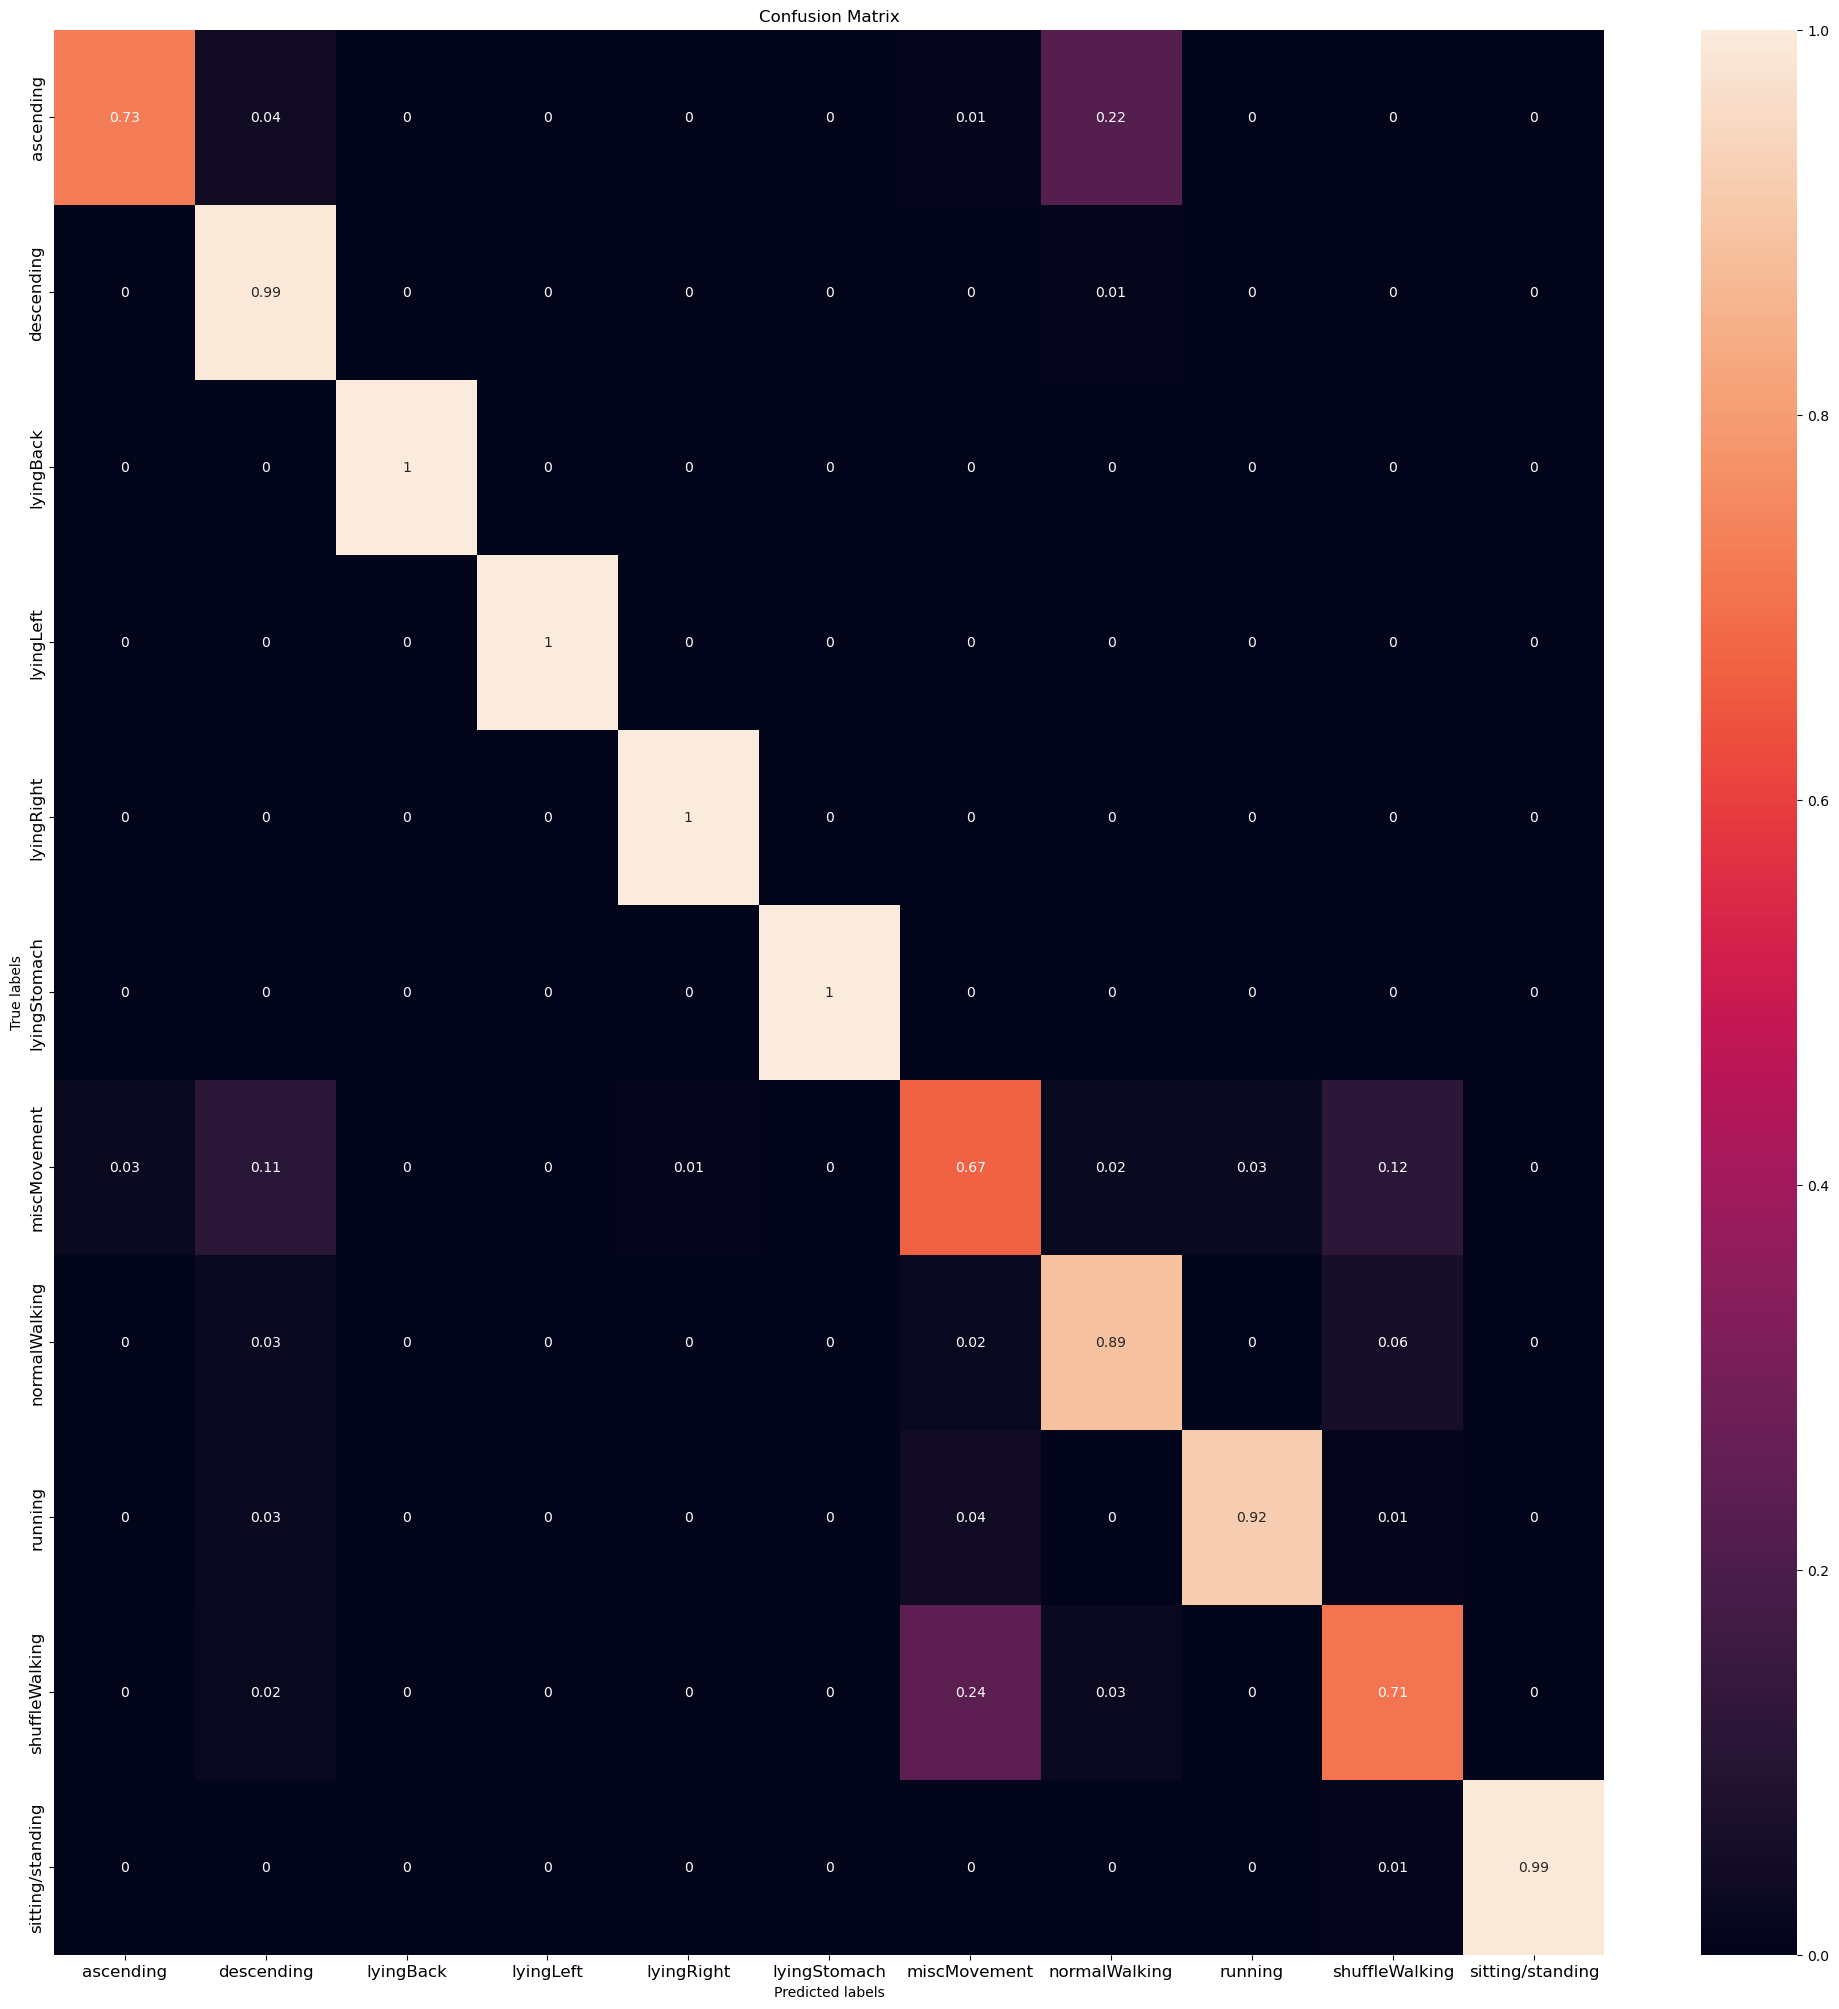

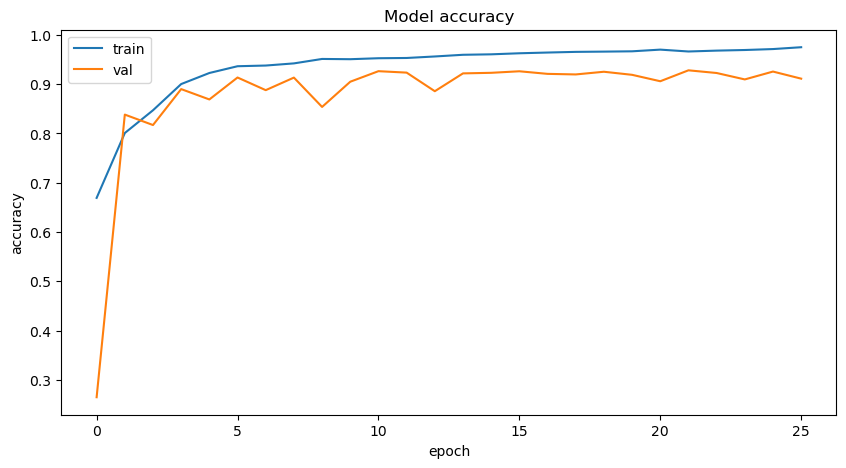

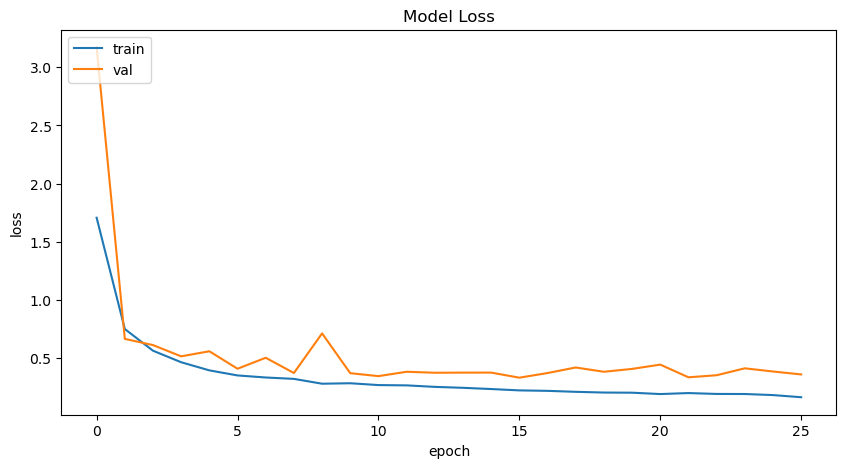

In [401]:
show_report(Conv_LSTM_model_v1, Conv_LSTM_model_v1_history)

## Bidirectional LSTM

### Bidirectional LSTM Model v1 Training
Test accuracy: 80%

In [48]:
def BiLSTM_model_v1(window_size, n_features, n_classes):
    model = Sequential()
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(200, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), 
                            input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(BatchNormalization())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(n_classes, activation='softmax'))
    
    optimizer = optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics = ['accuracy'])
    
    print(model.summary())
    return model

In [49]:
print(f"Training on BiLSTM Model v1:")

window_size = X_train.shape[1]
n_features = X_train.shape[2]
n_classes = len(class_labels)

BiLSTM_model_v1 = BiLSTM_model_v1(window_size, n_features, n_classes)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

callbacks_list = [early_stopping, reduce_lr]

BiLSTM_model_v1_history = BiLSTM_model_v1.fit(
    X_train, y_train,
    batch_size=64, 
    epochs=30, 
    callbacks=callbacks_list,
    validation_data=(X_test, y_test))

test_loss, test_accuracy = BiLSTM_model_v1.evaluate(X_test, y_test)

print(f'Test accuracy: {test_accuracy *100:.2f}%%')

Training on BiLSTM Model v1:
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 50, 400)          331200    
 l)                                                              
                                                                 
 batch_normalization_7 (Batc  (None, 50, 400)          1600      
 hNormalization)                                                 
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              400800    
 nal)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)        